In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/demouser/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [5]:
from networks import IMVTensorLSTM

In [6]:
data1 = pd.read_csv("SML2010/NEW-DATA-1.T15.txt", sep=' ')
data2 = pd.read_csv("SML2010/NEW-DATA-2.T15.txt", sep=' ')

In [7]:
target = '3:Temperature_Comedor_Sensor'
cols = [
    '3:Temperature_Comedor_Sensor',
 '4:Temperature_Habitacion_Sensor',
 '5:Weather_Temperature',
 '6:CO2_Comedor_Sensor',
 '7:CO2_Habitacion_Sensor',
 '8:Humedad_Comedor_Sensor',
 '9:Humedad_Habitacion_Sensor',
 '10:Lighting_Comedor_Sensor',
 '11:Lighting_Habitacion_Sensor',
 '12:Precipitacion',
 '13:Meteo_Exterior_Crepusculo',
 '14:Meteo_Exterior_Viento',
 '15:Meteo_Exterior_Sol_Oest',
 '16:Meteo_Exterior_Sol_Est',
 '20:Exterior_Entalpic_2',
 '21:Exterior_Entalpic_turbo',
 '22:Temperature_Exterior_Sensor']

In [8]:
data1.head()

# Unnamed: 1   1:Date   2:Time  3:Temperature_Comedor_Sensor  \
0  13/03/2012      11:45  18.1875  17.8275                           0.0   
1  13/03/2012      12:00  18.4633  18.1207                           6.8   
2  13/03/2012      12:15  18.7673  18.4367                          17.0   
3  13/03/2012      12:30  19.0727  18.7513                          18.0   
4  13/03/2012      12:45  19.3721  19.0414                          20.0   

   4:Temperature_Habitacion_Sensor  5:Weather_Temperature  \
0                          216.560                221.920   
1                          219.947                220.363   
2                          219.403                218.933   
3                          218.613                217.045   
4                          217.714                216.080   

   6:CO2_Comedor_Sensor  7:CO2_Habitacion_Sensor  8:Humedad_Comedor_Sensor  \
0               39.9125                  42.4150                   81.6650   
1               39.9267                  42.2453                   81.7413   
2               39.7720                  42.2267                   81.4240   
3               39.7760                  42.0987                   81.5013   
4               39.7757                  42.0686                   81.4657   

   ...  15:Meteo_Exterior_Sol_Oest  16:Meteo_Exterior_Sol_Est  \
0  ...                     95436.8                    758.880   
1  ...                     95436.8                    762.069   
2  ...                     95398.6                    766.251   
3  ...                     95360.3                    766.037   
4  ...                     95354.9                    762.743   

   17:Meteo_Exterior_Sol_Sud  18:Meteo_Exterior_Piranometro  \
0                          0                              0   
1                          0                              0   
2                          0                              0   
3                          0                              0   
4                          0                              0   

   19:Exterior_Entalpic_1  20:Exterior_Entalpic_2  21:Exterior_Entalpic_turbo  \
0                       0                 18.1150                     48.3750   
1                       0                 18.4147                     47.8080   
2                       0                 18.8533                     47.4320   
3                       0                 19.2907                     47.0240   
4                       0                 19.7400                     45.4743   

   22:Temperature_Exterior_Sensor  23:Humedad_Exterior_Sensor  24:Day_Of_Week  
0                             2.0                         NaN             NaN  
1                             2.0                         NaN             NaN  
2                             2.0                         NaN             NaN  
3                             2.0                         NaN             NaN  
4                             2.0                         NaN             NaN  

[5 rows x 26 columns]

In [9]:
train_size = 3200
val_size = 400
depth = 10
batch_size = 128
prediction_horizon = 1

In [10]:
X_train1 = np.zeros((len(data1), depth, len(cols)))
y_train1 = np.zeros((len(data1), 1))

In [11]:
for i, name in enumerate(cols):
    for j in range(depth):
        X_train1[:, j, i] = data1[name].shift(depth - j - 1).fillna(method="bfill")
y_train1 = data1[target].shift(-prediction_horizon).fillna(method='ffill')

In [12]:
X_train1 = X_train1[depth:-prediction_horizon]
y_train1 = y_train1[depth:-prediction_horizon]

In [13]:
X2 = np.zeros((len(data2), depth, len(cols)))
y2 = np.zeros((len(data2), 1))

In [14]:
for i, name in enumerate(cols):
    for j in range(depth):
        X2[:, j, i] = data2[name].shift(depth - j - 1).fillna(method="bfill")
y2 = data2[target].shift(-prediction_horizon).fillna(method='ffill')

In [15]:
X_train2 = X2[:train_size - len(data1)]
y_train2 = y2[:train_size - len(data1)]

X_val = X2[train_size - len(data1):train_size - len(data1) + val_size]
y_val = y2[train_size - len(data1):train_size - len(data1) + val_size]

X_test = X2[train_size - len(data1) + val_size:]
y_test = y2[train_size - len(data1) + val_size:]

In [16]:
X_train2 = X_train2[depth:]
y_train2 = y_train2[depth:]

In [17]:
X_train = np.concatenate([X_train1, X_train2], axis=0)
y_train = np.concatenate([y_train1, y_train2], axis=0)

In [18]:
X_train.shape, y_train.shape

((3179, 10, 17), (3179,))

In [19]:
X_train_min, y_train_min = X_train.min(axis=0), y_train.min(axis=0)
X_train_max, y_train_max = X_train.max(axis=0), y_train.max(axis=0)

In [20]:
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)

y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)


In [21]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val.values)
y_test_t = torch.Tensor(y_test.values)

In [22]:
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=batch_size)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=batch_size)


In [28]:
model = IMVTensorLSTM(X_train.shape[2], 1, 128).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [31]:
import time

Saving...
Iter:  0 train:  0.3793104963667754 val:  0.21588897855525244
Iter time:  3.2695907186716795
mse:  22.558296 mae:  3.9538496


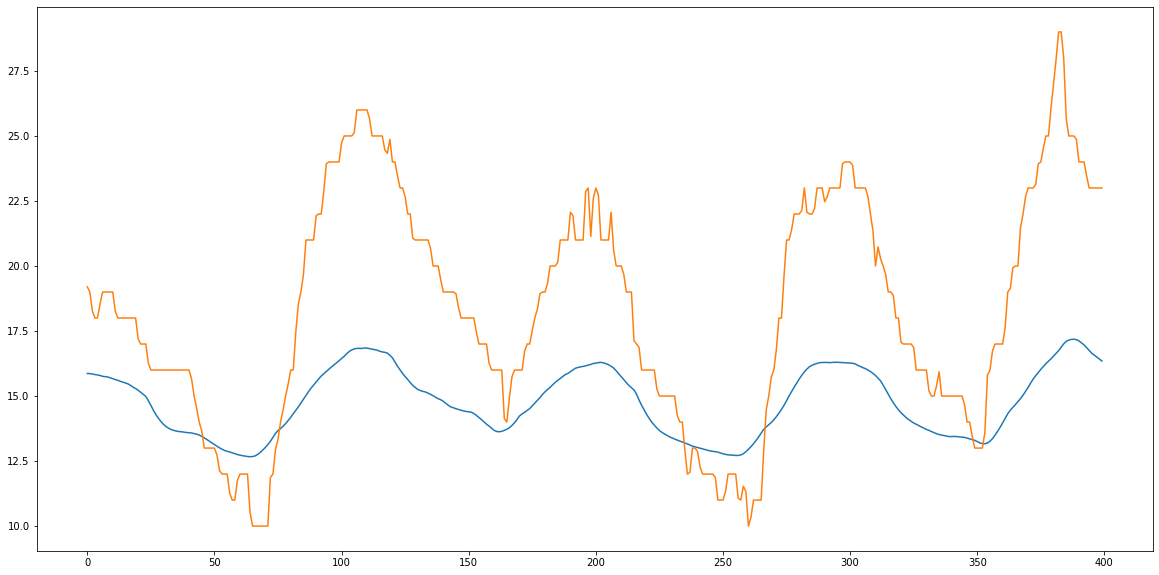

Saving...
Iter:  1 train:  0.1258891092597408 val:  0.09010276165135062
Iter time:  1.0992612093687057
Saving...
Iter:  2 train:  0.0828404601918191 val:  0.0803355095330821
Iter time:  1.0975713450461626
Saving...
Iter:  3 train:  0.07217456134948542 val:  0.07607711032371761
Iter time:  1.096102949231863
Saving...
Iter:  4 train:  0.06871835981792372 val:  0.07325750089141585
Iter time:  1.1252497481182218
Saving...
Iter:  5 train:  0.06412710450787187 val:  0.07057303531866668
Iter time:  1.138613793067634
Saving...
Iter:  6 train:  0.05671296214451889 val:  0.057572062650705094
Iter time:  1.1391697116196156
Iter:  7 train:  0.0464013094324165 val:  0.060282215689354234
Iter time:  1.1141446875408292
Saving...
Iter:  8 train:  0.04342838124227763 val:  0.05356907924541573
Iter time:  1.1394731737673283
Saving...
Iter:  9 train:  0.03884222256005097 val:  0.047984551019665596
Iter time:  1.159442220814526
Saving...
Iter:  10 train:  0.03882696855778079 val:  0.0416694951711674
Iter 

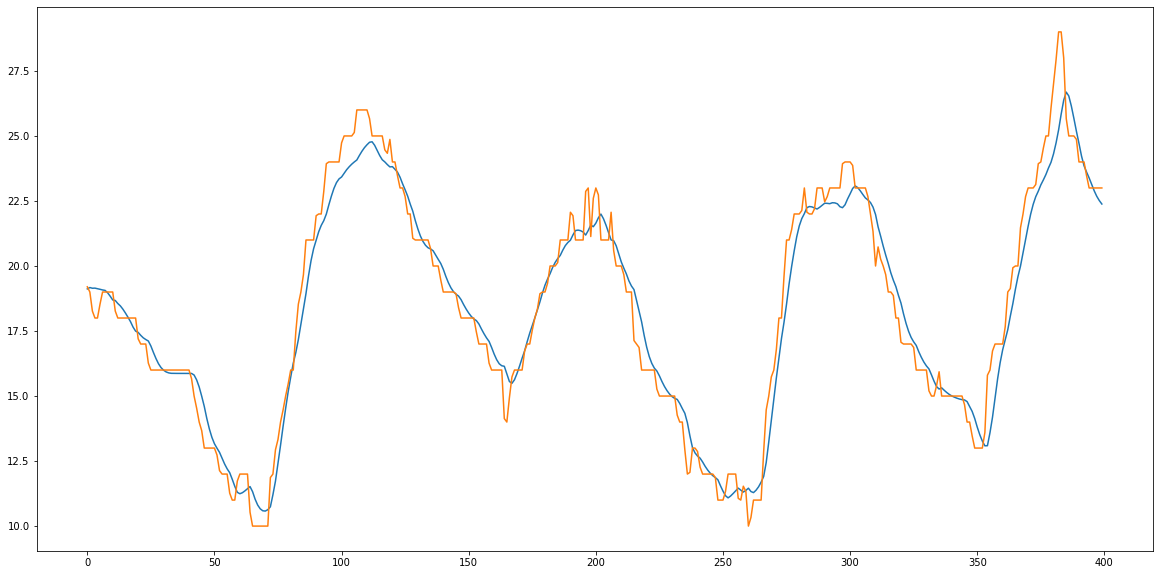

Iter:  11 train:  0.03645784815673161 val:  0.043373071272942765
Iter time:  1.1233640294522047
Saving...
Iter:  12 train:  0.034188735437118374 val:  0.039269953956821986
Iter time:  1.151690480299294
Iter:  13 train:  0.032860683395875015 val:  0.051414551311047926
Iter time:  1.1210747919976711
Saving...
Iter:  14 train:  0.032750440242841586 val:  0.03599909603785354
Iter time:  1.146981492638588
Iter:  15 train:  0.031036904480452425 val:  0.04384192416524871
Iter time:  1.1215938217937946
Iter:  16 train:  0.030745670016827938 val:  0.04089852282962442
Iter time:  1.124241934157908
Saving...
Iter:  17 train:  0.029816285698817415 val:  0.035410055485459474
Iter time:  1.1496830694377422
Saving...
Iter:  18 train:  0.03205791448632838 val:  0.03457418139947769
Iter time:  1.1161525594070554
Iter:  19 train:  0.02882047393716973 val:  0.04068369247783488
Iter time:  1.091618132777512
Iter:  20 train:  0.030492306950850586 val:  0.04247281235724349
Iter time:  1.0937950378283858
mse

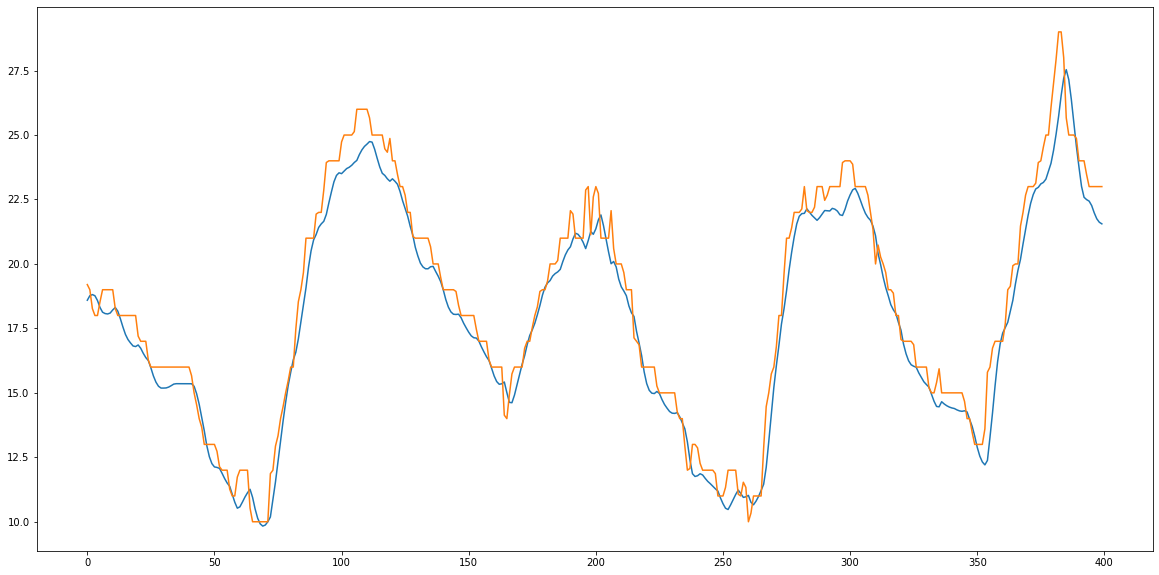

Saving...
Iter:  21 train:  0.02792564215669929 val:  0.03296233972494922
Iter time:  1.1178460409864783
Saving...
Iter:  22 train:  0.02855035682922473 val:  0.032941886988365934
Iter time:  1.1284266849979758
Iter:  23 train:  0.028746878358798415 val:  0.03469806600431846
Iter time:  1.1273962380364537
Saving...
Iter:  24 train:  0.02872525041832145 val:  0.032523978562153215
Iter time:  1.1344679361209273
Iter:  25 train:  0.02873730617633292 val:  0.03528125539535502
Iter time:  1.0978442709892988
Iter:  26 train:  0.03224573182240752 val:  0.034786176902152126
Iter time:  1.1025094548240304
Iter:  27 train:  0.030243772660045812 val:  0.03326149830098327
Iter time:  1.1028852052986622
Iter:  28 train:  0.028120190151561704 val:  0.03289573194855779
Iter time:  1.129081217572093
Saving...
Iter:  29 train:  0.026555753027155963 val:  0.03219159642443304
Iter time:  1.1506064804270864
Iter:  30 train:  0.02647021946406952 val:  0.03898720923997503
Iter time:  1.1319218399003148
mse:

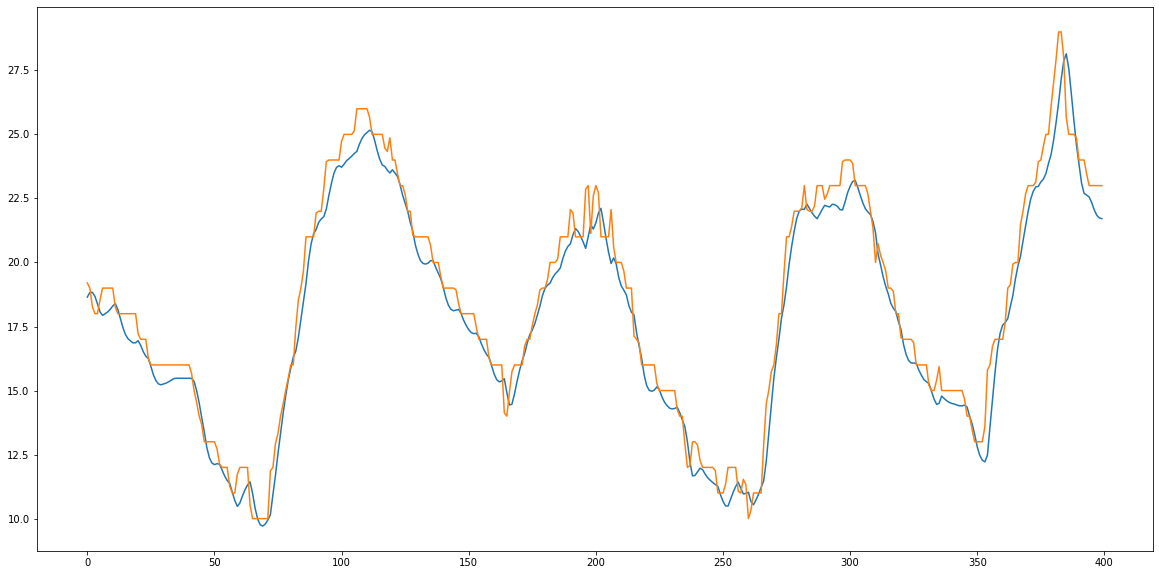

Saving...
Iter:  31 train:  0.027619376050929546 val:  0.031606061919250354
Iter time:  1.1557804429903626
Iter:  32 train:  0.02817436233582557 val:  0.03531225163237401
Iter time:  1.128727956674993
Iter:  33 train:  0.025661460878384158 val:  0.037790688734253966
Iter time:  1.1322465427219868
Iter:  34 train:  0.025978531730407633 val:  0.03201269871536665
Iter time:  1.0970989894121885
Iter:  35 train:  0.025926091765600512 val:  0.032146226713057745
Iter time:  1.0028419736772776
Saving...
Iter:  36 train:  0.025585319928606014 val:  0.03063372292536254
Iter time:  1.088852521032095
Iter:  37 train:  0.02598646229092991 val:  0.031006677121169612
Iter time:  1.0529934586957097
Saving...
Iter:  38 train:  0.02666965036542415 val:  0.029954347196507136
Iter time:  1.0665317624807358
Iter:  39 train:  0.025138315815550035 val:  0.031156413939483752
Iter time:  1.0641327956691384
Iter:  40 train:  0.02450975292803538 val:  0.03249062364492389
Iter time:  1.0684755323454738
mse:  0.51

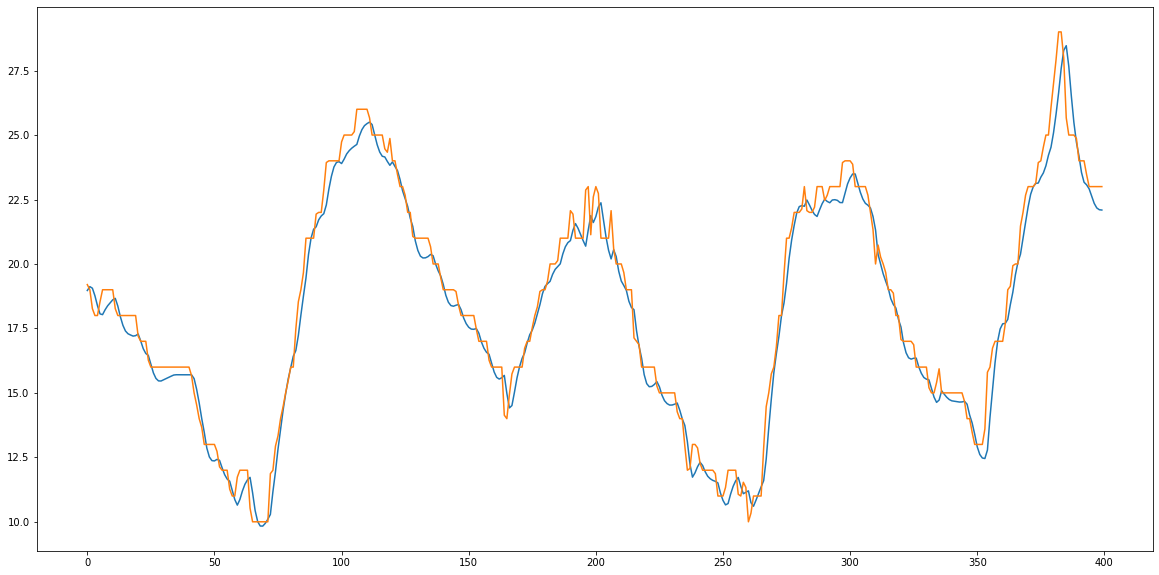

Iter:  41 train:  0.025167872873671962 val:  0.0315687127655571
Iter time:  1.0313759064301848
Iter:  42 train:  0.02474687790432175 val:  0.03446729796698123
Iter time:  1.088672953657806
Iter:  43 train:  0.024483808546287532 val:  0.03110310825218862
Iter time:  1.077029320411384
Saving...
Iter:  44 train:  0.024546722035883612 val:  0.029946169042043544
Iter time:  1.0643524592742324
Saving...
Iter:  45 train:  0.024262444269543503 val:  0.028894892439545076
Iter time:  1.0717486524954438
Iter:  46 train:  0.024011981257193768 val:  0.03325208644308064
Iter time:  1.0474322577938437
Saving...
Iter:  47 train:  0.023241419169688575 val:  0.02867326827912668
Iter time:  1.0658373553305864
Iter:  48 train:  0.024399779483908087 val:  0.028741568814042686
Iter time:  1.0692690014839172
Iter:  49 train:  0.02366269786659728 val:  0.03013204565548584
Iter time:  1.0576446885243058
Iter:  50 train:  0.02285120981841111 val:  0.02882376319948147
Iter time:  1.0424164710566401
mse:  0.40211

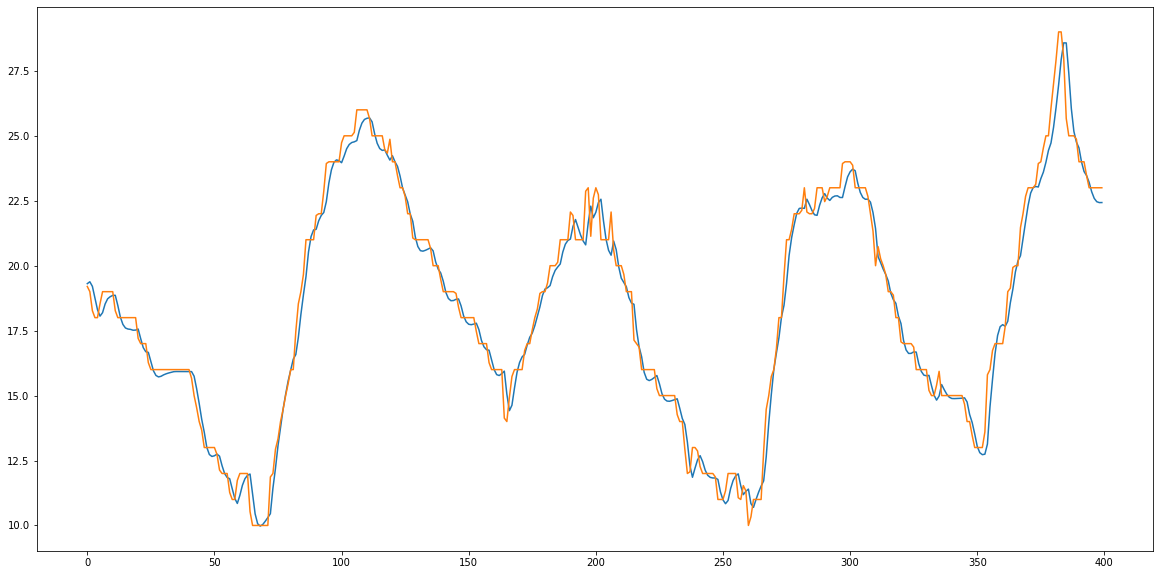

Saving...
Iter:  51 train:  0.023708063851017366 val:  0.028574125820381664
Iter time:  1.0537896677851677
Iter:  52 train:  0.024055875961228153 val:  0.03008686827247803
Iter time:  1.038369040004909
Saving...
Iter:  53 train:  0.022680181515050007 val:  0.028309652361072725
Iter time:  1.0636152494698763
Iter:  54 train:  0.02246420242816648 val:  0.029496848609620315
Iter time:  1.0392094729468226
Iter:  55 train:  0.023140301275688314 val:  0.02923342923796245
Iter time:  1.0421537961810827
Iter:  56 train:  0.0236470046455946 val:  0.03254798419097512
Iter time:  1.0418751891702414
Saving...
Iter:  57 train:  0.022889730915175193 val:  0.026881719417349285
Iter time:  1.0680634658783674
Iter:  58 train:  0.022554824159950613 val:  0.028703122632426838
Iter time:  1.0529118608683348
Iter:  59 train:  0.0225040434890211 val:  0.027952074035677718
Iter time:  1.03996538836509
Iter:  60 train:  0.021842738262601184 val:  0.03041382693344752
Iter time:  1.041637985035777
mse:  0.44770

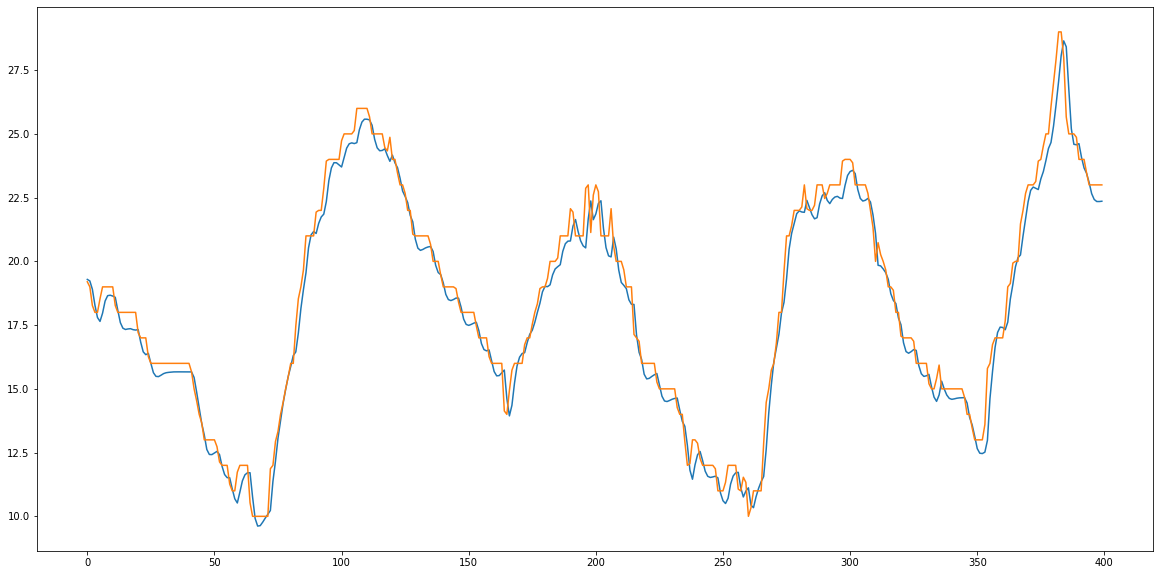

Saving...
Iter:  61 train:  0.022434471811872896 val:  0.026713717457946623
Iter time:  1.0500455684959888
Saving...
Iter:  62 train:  0.021704514639193522 val:  0.02665507116134434
Iter time:  1.0676616914570332
Iter:  63 train:  0.021670050407971583 val:  0.027993397641035023
Iter time:  1.052680212073028
Iter:  64 train:  0.021487229349635824 val:  0.026983850181072622
Iter time:  1.04474214091897
Iter:  65 train:  0.021675533885728987 val:  0.028388804778899105
Iter time:  1.033784732222557
Iter:  66 train:  0.02136085588031578 val:  0.027006809787741035
Iter time:  1.0459326207637787
Iter:  67 train:  0.021196299580367898 val:  0.02740938916858376
Iter time:  1.060773947276175
Iter:  68 train:  0.02281704864438139 val:  0.026854481765643503
Iter time:  1.0379718970507383
Iter:  69 train:  0.022009847870840437 val:  0.02912276450941208
Iter time:  1.072946979664266
Iter:  70 train:  0.02118382824688127 val:  0.026752577133765994
Iter time:  1.0402273144572973
mse:  0.3463989 mae:  

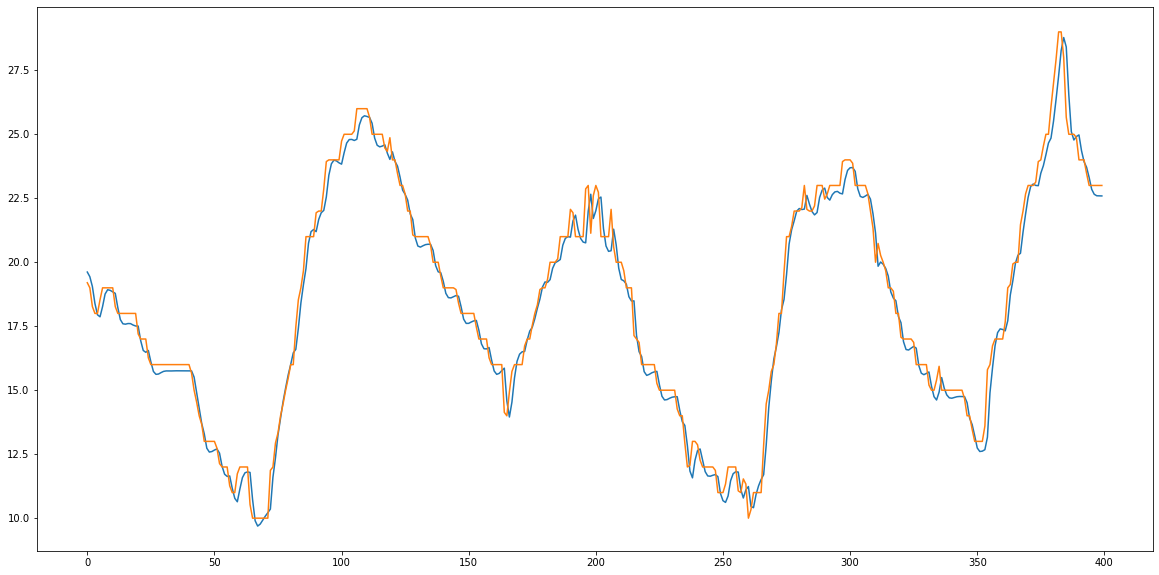

Saving...
Iter:  71 train:  0.02086988305240464 val:  0.02603120801439712
Iter time:  1.0867823837324977
Iter:  72 train:  0.020778222009893946 val:  0.026128630620700543
Iter time:  1.046887706965208
Saving...
Iter:  73 train:  0.02125182412516438 val:  0.02602532844822311
Iter time:  1.0768660679459572
Iter:  74 train:  0.0205624971219024 val:  0.028849090141503306
Iter time:  1.0411710431799293
Saving...
Iter:  75 train:  0.02076198559797165 val:  0.02599039802806481
Iter time:  1.0667590172961354
Saving...
Iter:  76 train:  0.0210178283838945 val:  0.025987748107619144
Iter time:  0.9867100827395916
Saving...
Iter:  77 train:  0.020819786651675668 val:  0.02498693627779038
Iter time:  1.057547589763999
Iter:  78 train:  0.02232110417066487 val:  0.025042106514800547
Iter time:  1.0397921595722437
Iter:  79 train:  0.020516940290196732 val:  0.025068924094668887
Iter time:  1.0432754969224334
Iter:  80 train:  0.020772515188641094 val:  0.026588404082133168
Iter time:  1.04076139722

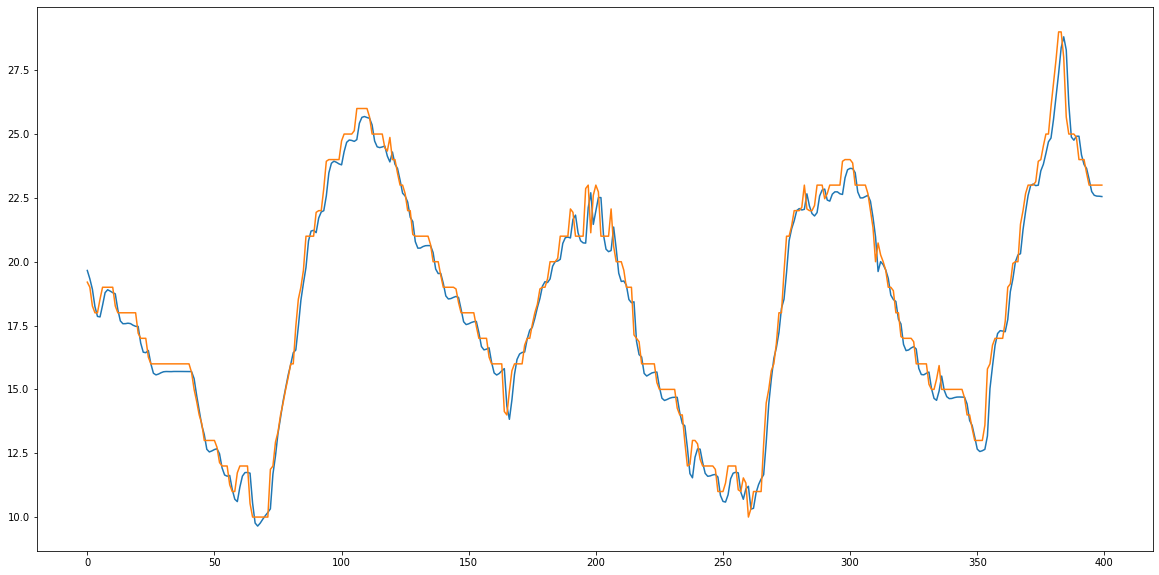

Iter:  81 train:  0.021648073399090997 val:  0.025549014217742107
Iter time:  0.9983847215771675
Iter:  82 train:  0.020948702494215387 val:  0.025390540544662867
Iter time:  0.93075583409518
Iter:  83 train:  0.020253735423193555 val:  0.026909215290625395
Iter time:  1.0034001804888248
Iter:  84 train:  0.02232275265046755 val:  0.0250574670547251
Iter time:  1.0438420604914427
Saving...
Iter:  85 train:  0.020946498972333853 val:  0.024962488452354027
Iter time:  1.0538612809032202
Iter:  86 train:  0.020440979464752703 val:  0.02516186503050598
Iter time:  1.0491117322817445
Iter:  87 train:  0.02035252706092011 val:  0.025666014017956037
Iter time:  1.0429806848987937
Saving...
Iter:  88 train:  0.021442680823322742 val:  0.02449757758899007
Iter time:  1.0812442218884826
Iter:  89 train:  0.0200162219071302 val:  0.025166944679812536
Iter time:  1.0459066033363342
Iter:  90 train:  0.020272256790942297 val:  0.02698241720499833
Iter time:  1.0376588674262166
mse:  0.35237658 mae:

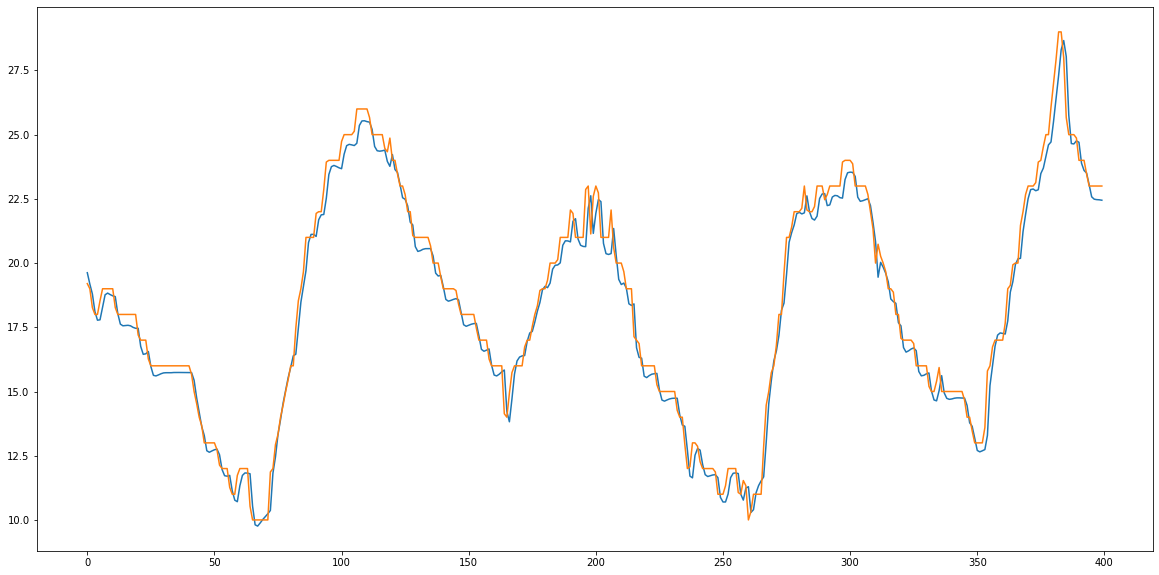

Iter:  91 train:  0.020688322920809857 val:  0.027565951949975267
Iter time:  0.9424081761389971
Saving...
Iter:  92 train:  0.020369983559024647 val:  0.024161358771006298
Iter time:  1.041502384468913
Iter:  93 train:  0.019435283071509827 val:  0.025154226092850545
Iter time:  1.054408773779869
Iter:  94 train:  0.01961682477823987 val:  0.024452415382125302
Iter time:  1.0424077045172453
Iter:  95 train:  0.019635779567342287 val:  0.02533227929234299
Iter time:  1.0380651960149407
Saving...
Iter:  96 train:  0.020544337024662077 val:  0.02351581641528017
Iter time:  1.067134702578187
Iter:  97 train:  0.020099394905578088 val:  0.025619458396734053
Iter time:  1.0391590623185039
Iter:  98 train:  0.020535182138219234 val:  0.02808642142254305
Iter time:  1.037852886132896
Iter:  99 train:  0.020179154110954174 val:  0.023875475079087535
Iter time:  1.0419668480753899
Iter:  100 train:  0.01952011134472462 val:  0.025319174406103047
Iter time:  1.0406539142131805
mse:  0.31027326 m

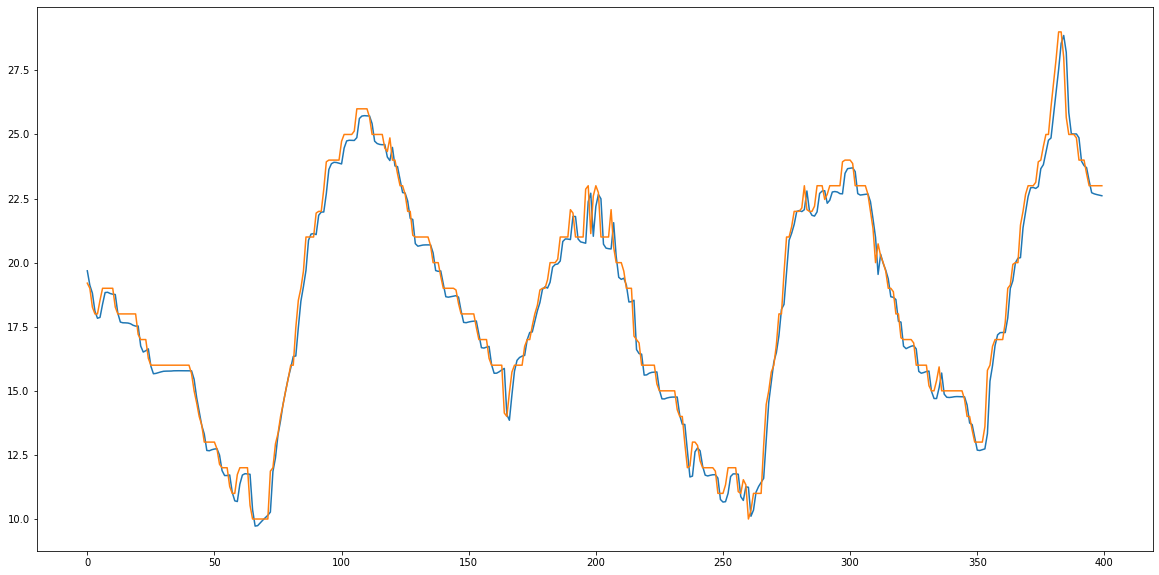

Saving...
Iter:  101 train:  0.019333382206104616 val:  0.023504307719049985
Iter time:  1.0593649772927165
Iter:  102 train:  0.019201627096577866 val:  0.02773982661019472
Iter time:  1.0405348250642419
Saving...
Iter:  103 train:  0.01964048955223334 val:  0.023421619717680853
Iter time:  1.0638302192091942
Iter:  104 train:  0.019393180593230003 val:  0.027984809583642006
Iter time:  1.047773975878954
Iter:  105 train:  0.019814022154807553 val:  0.024564606386058268
Iter time:  1.038415719754994
Iter:  106 train:  0.020330854238314253 val:  0.023690531526599282
Iter time:  1.0387260420247912
Iter:  107 train:  0.01916664792114616 val:  0.02367250472748241
Iter time:  1.039839243516326
Iter:  108 train:  0.018901048384548744 val:  0.023473245561749827
Iter time:  1.0450346656143665
Iter:  109 train:  0.01966816474202642 val:  0.025201322703651854
Iter time:  1.0415416285395622
Iter:  110 train:  0.019089975805041594 val:  0.02623786701927764
Iter time:  1.0390256233513355
mse:  0.3

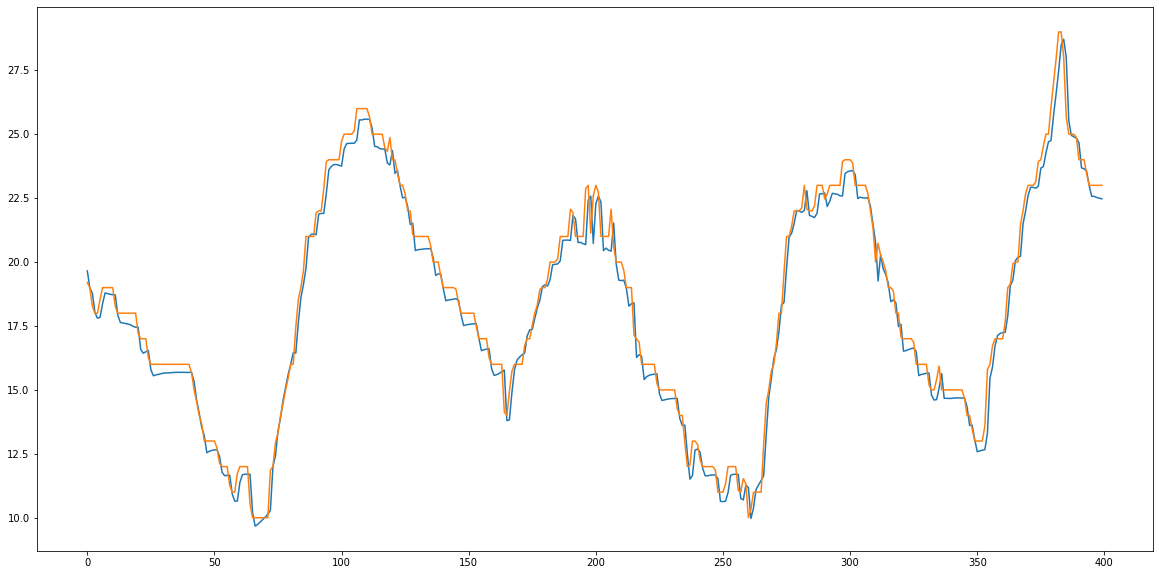

Iter:  111 train:  0.01968732628895576 val:  0.02361556972870991
Iter time:  1.0363879930227995
Iter:  112 train:  0.01892247976963683 val:  0.02374747328352211
Iter time:  0.9696905612945557
Saving...
Iter:  113 train:  0.018650298485201056 val:  0.023349125863896057
Iter time:  1.0657050926238298
Saving...
Iter:  114 train:  0.018656383053232323 val:  0.023304334367198778
Iter time:  1.0778316669166088
Iter:  115 train:  0.02028373753283395 val:  0.02493998945076121
Iter time:  1.0452271457761526
Iter:  116 train:  0.01948311471110787 val:  0.023347142506838548
Iter time:  1.0434897718951106
Iter:  117 train:  0.019649084538661366 val:  0.02454744097383769
Iter time:  1.0490977400913835
Iter:  118 train:  0.018646497680901656 val:  0.02348617634952223
Iter time:  1.0513577777892351
Saving...
Iter:  119 train:  0.019215053272422636 val:  0.02303567246357896
Iter time:  1.074376861564815
Iter:  120 train:  0.018483707326389074 val:  0.023163477369994686
Iter time:  1.0456800013780594
m

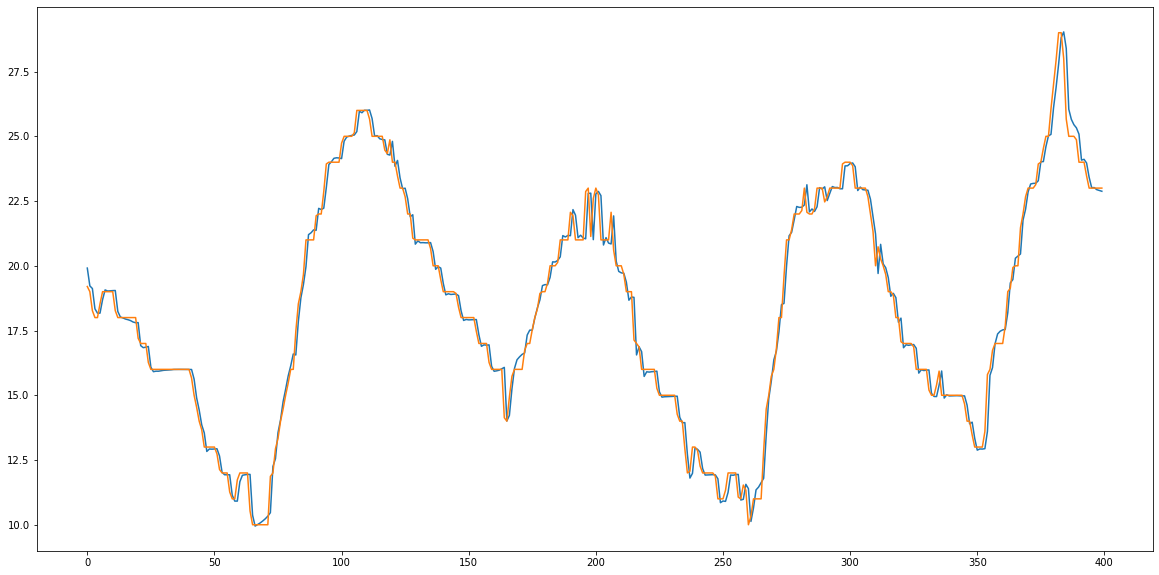

Saving...
Iter:  121 train:  0.01857578019286026 val:  0.022931054617175994
Iter time:  1.0626614280045033
Iter:  122 train:  0.01855461550253942 val:  0.02344473796583519
Iter time:  1.0696072205901146
Iter:  123 train:  0.018308290405729594 val:  0.022958714671398536
Iter time:  1.0380902756005526
Iter:  124 train:  0.018346903059969798 val:  0.024621500233564925
Iter time:  1.037807789631188
Iter:  125 train:  0.01826676192356077 val:  0.02312502058775733
Iter time:  1.0437153512611985
Iter:  126 train:  0.018354853422924557 val:  0.02295467737900169
Iter time:  1.0335192857310176
Saving...
Iter:  127 train:  0.018441274142028497 val:  0.02289823113204984
Iter time:  1.0684069953858852
Iter:  128 train:  0.020392408599819074 val:  0.02419264120562096
Iter time:  1.0403881212696433
Iter:  129 train:  0.01904351440296796 val:  0.023166385223795424
Iter time:  1.0422239685431123
Iter:  130 train:  0.018356357325776597 val:  0.024045391537855385
Iter time:  1.0166749777272344
mse:  0.27

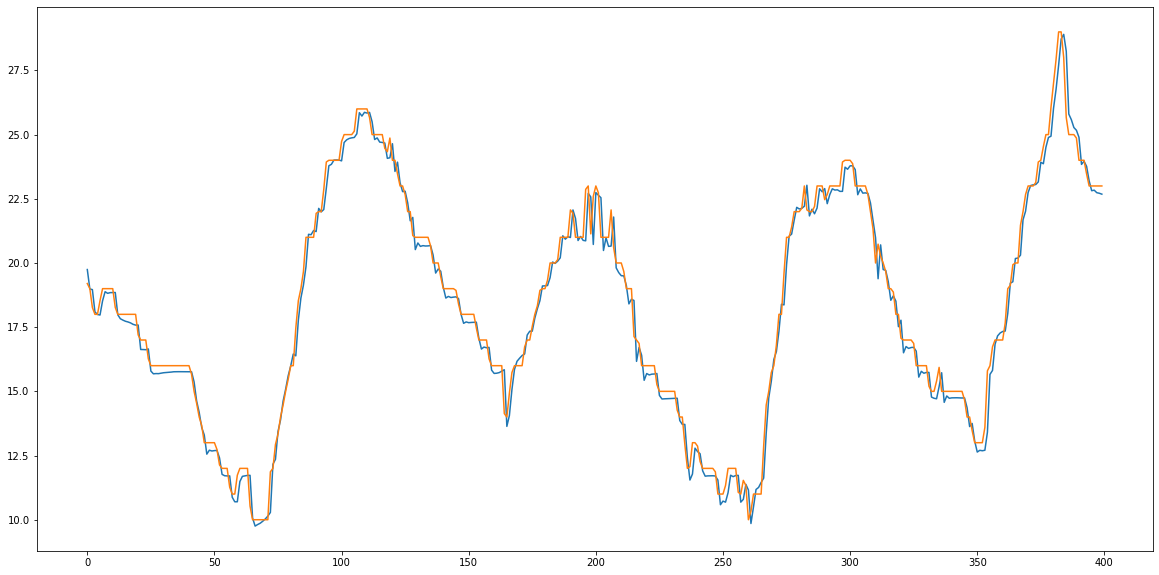

Iter:  131 train:  0.018931758453607093 val:  0.023454422702473707
Iter time:  1.0781265571713448
Iter:  132 train:  0.018408221461768254 val:  0.02300337083912147
Iter time:  1.0391151057556272
Iter:  133 train:  0.018338258023889206 val:  0.023053025782675308
Iter time:  1.0376872885972261
Iter:  134 train:  0.018106580012901188 val:  0.023912463471503907
Iter time:  1.0449228454381227
Iter:  135 train:  0.018421906460774507 val:  0.023157018902113413
Iter time:  1.0347658758983016
Iter:  136 train:  0.018628809020894355 val:  0.023039169862166534
Iter time:  1.043689570389688
Iter:  137 train:  0.01815666274234343 val:  0.02329475824607733
Iter time:  1.0018917312845588
Iter:  138 train:  0.018112871515945914 val:  0.02299371838584965
Iter time:  1.035799140110612
Iter:  139 train:  0.018843608049115067 val:  0.02469044607426198
Iter time:  1.0345018655061722
Iter:  140 train:  0.01935661601848536 val:  0.023574299729215254
Iter time:  1.0439975932240486
mse:  0.26898178 mae:  0.337

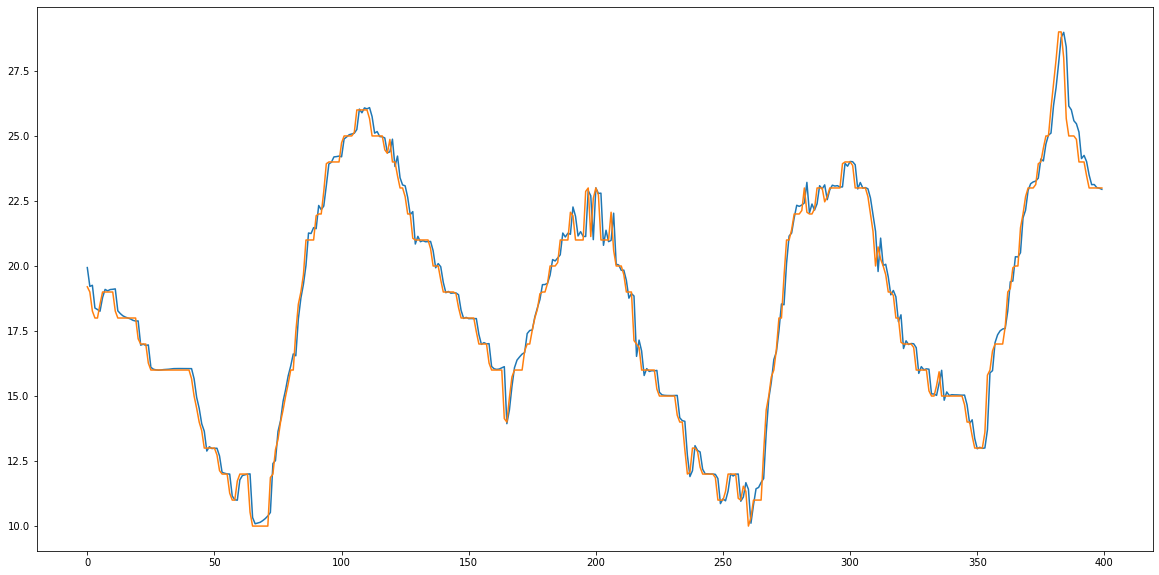

Iter:  141 train:  0.018598092672436978 val:  0.024258945165288308
Iter time:  1.0320435827597976
Iter:  142 train:  0.01907124326559653 val:  0.023254690694049417
Iter time:  1.0415622424334288
Iter:  143 train:  0.019591395426363768 val:  0.0232359673487364
Iter time:  1.042927316389978
Iter:  144 train:  0.018256180940886064 val:  0.02323132469469531
Iter time:  1.0343608250841498
Iter:  145 train:  0.01865120162161163 val:  0.02295147975984237
Iter time:  1.0347056854516268
Iter:  146 train:  0.018108783665528448 val:  0.0233458706723621
Iter time:  1.0478327823802829
Iter:  147 train:  0.018193972525138196 val:  0.023439042517447106
Iter time:  1.0406582839787006
Iter:  148 train:  0.018640231003074513 val:  0.024032122119957342
Iter time:  1.0387656027451158
Iter:  149 train:  0.018165428148999428 val:  0.023767758630905206
Iter time:  1.0367992259562016
Iter:  150 train:  0.018281850798510232 val:  0.024002856649881096
Iter time:  1.0389747880399227
mse:  0.27885032 mae:  0.3553

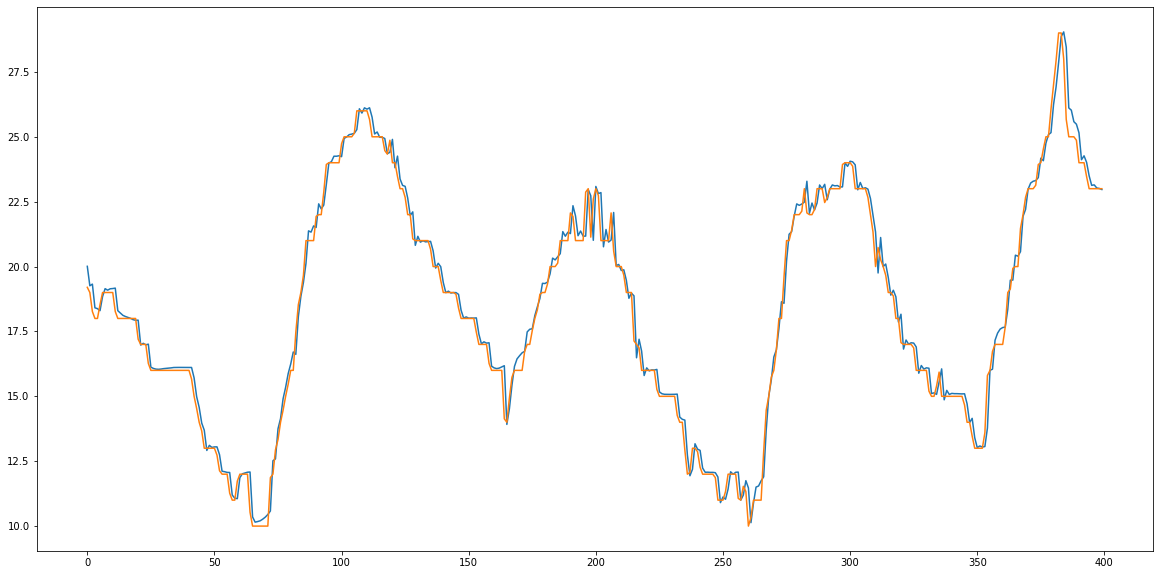

Iter:  151 train:  0.018554589960182978 val:  0.023343172993097273
Iter time:  1.0314185442402959
Iter:  152 train:  0.01834123646299378 val:  0.023901150442354423
Iter time:  1.0429796259850264
Iter:  153 train:  0.018496369306638172 val:  0.023315000180587374
Iter time:  1.0328311901539564
Iter:  154 train:  0.018857463889110287 val:  0.023843592368551037
Iter time:  1.0515678487718105
Iter:  155 train:  0.01836054543615264 val:  0.023344594679401882
Iter time:  1.031864301301539
Iter:  156 train:  0.01815067323698254 val:  0.023083464220530325
Iter time:  1.0401469273492694
Iter:  157 train:  0.01837732306206585 val:  0.023315375263090674
Iter time:  1.032248742878437
Iter:  158 train:  0.018146242996707404 val:  0.02336329176130315
Iter time:  1.0351218432188034
Iter:  159 train:  0.019436225218525022 val:  0.025278674416643623
Iter time:  1.0411166995763779
Iter:  160 train:  0.018543404030501177 val:  0.02353477200712841
Iter time:  1.043209900148213
mse:  0.26808053 mae:  0.3375

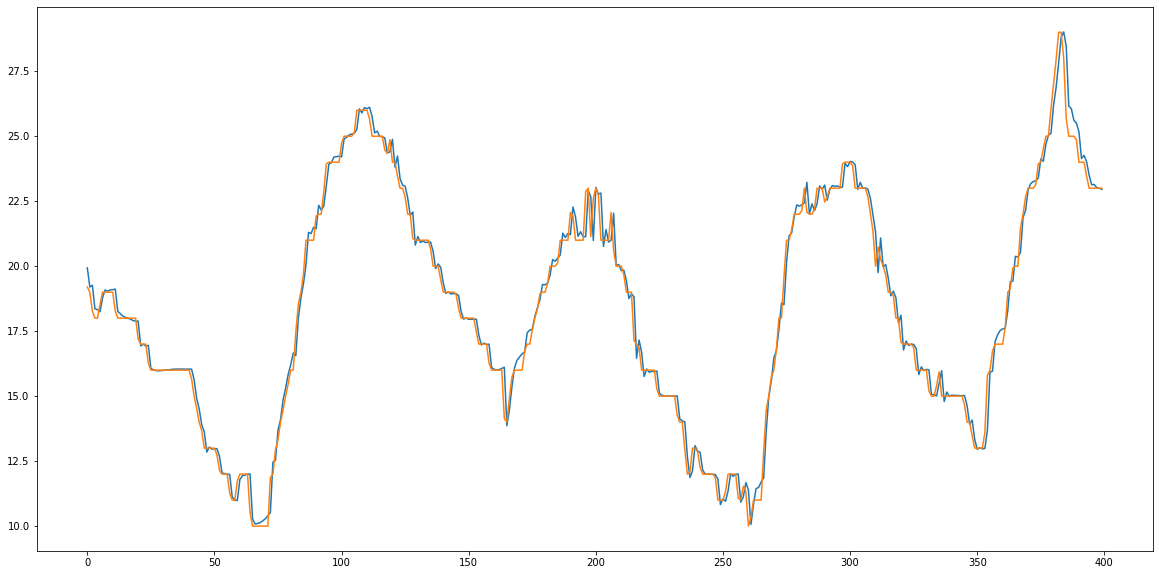

Iter:  161 train:  0.018014155663077198 val:  0.023085193884277082
Iter time:  1.0318792033940554


In [32]:
epochs = 1000
loss = nn.MSELoss()
patience = 35
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    iteration_start = time.monotonic()
    for batch_x, batch_y in train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output, alphas, betas = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "imv_lstm_sml2010.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    iteration_end = time.monotonic()
    print("Iter time: ", iteration_end - iteration_start)
    if(i % 10 == 0):
        preds = preds*(y_train_max - y_train_min) + y_train_min
        true = true*(y_train_max - y_train_min) + y_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [33]:
model.load_state_dict(torch.load("imv_lstm_sml2010.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [34]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    alphas = []
    betas = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output, a, b = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        alphas.append(a.detach().cpu().numpy())
        betas.append(b.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)
alphas = np.concatenate(alphas)
betas = np.concatenate(betas)

In [35]:
preds = preds*(y_train_max - y_train_min) + y_train_min
true = true*(y_train_max - y_train_min) + y_train_min

In [36]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [37]:
mse, mae

(0.14538495, 0.27598542)

In [38]:
mse**0.5

0.38129378755227145

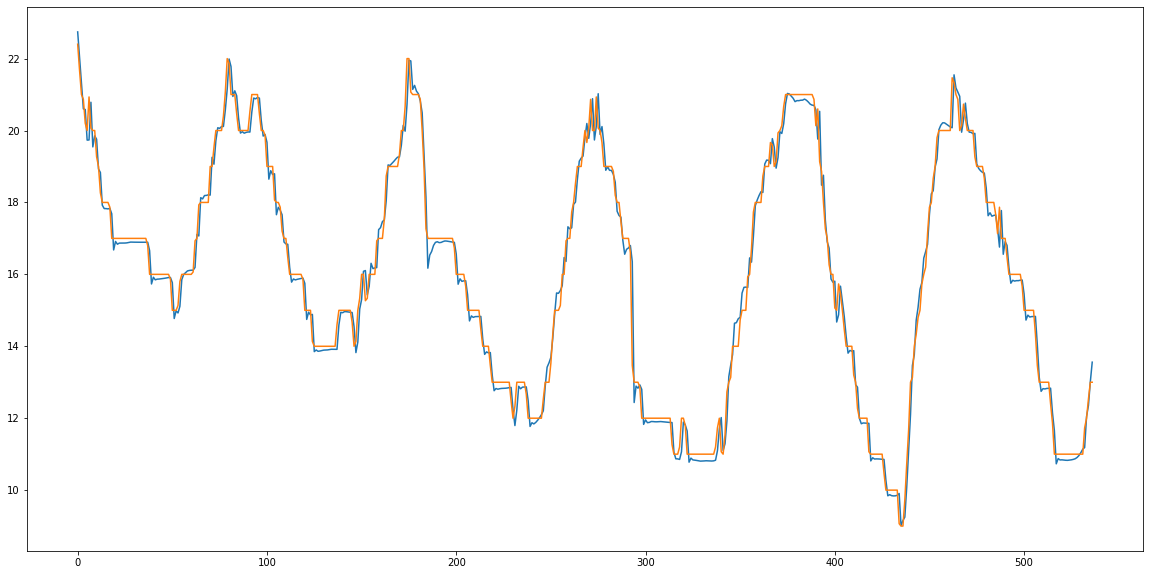

In [39]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()

In [40]:
alphas.shape

(537, 10, 17, 1)

In [41]:
betas.shape

(537, 17, 1)

In [42]:
alphas = alphas.mean(axis=0)
betas = betas.mean(axis=0)

In [43]:
alphas = alphas[..., 0]
betas = betas[..., 0]

In [44]:
alphas = alphas.transpose(1, 0)

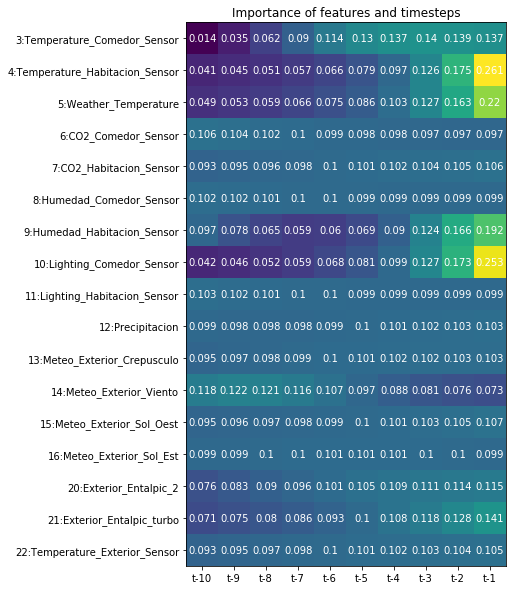

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(alphas)
ax.set_xticks(np.arange(X_train_t.shape[1]))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], -1, -1)])
ax.set_yticklabels(cols)
for i in range(len(cols)):
    for j in range(X_train_t.shape[1]):
        text = ax.text(j, i, round(alphas[i, j], 3),
                       ha="center", va="center", color="w")
ax.set_title("Importance of features and timesteps")
#fig.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x7f37ce1379e8>,
 <a list of 17 Text xticklabel objects>)

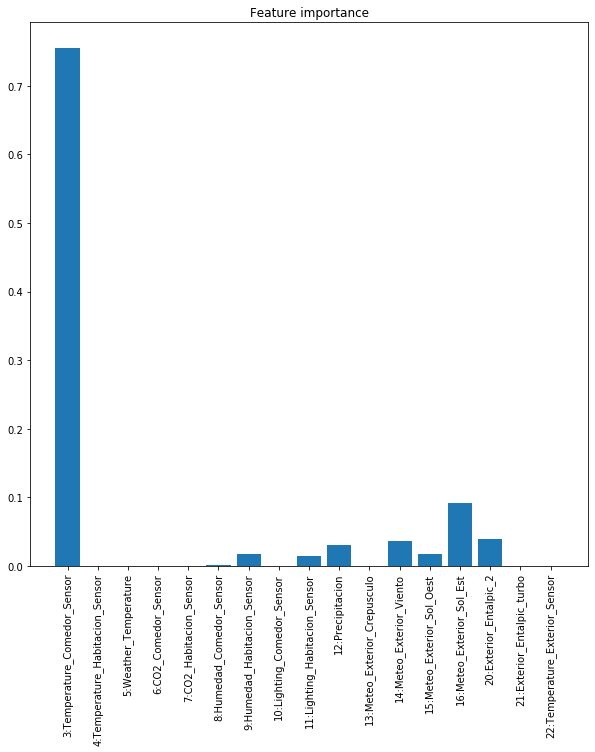

In [46]:
plt.figure(figsize=(10, 10))
plt.title("Feature importance")
plt.bar(range(len(cols)), betas)
plt.xticks(ticks=range(len(cols)), labels=cols, rotation=90)

In [47]:
# freeze weights 

In [49]:
attention_layers = ["F_alpha_n",
                "F_alpha_n_b",
                "F_beta_n",
                "F_beta_n_b",
                "F_alpha_1.bias",
                "F_alpha_1.weight",
                "F_beta_1.bias",
                "F_beta_1.weight"]
for p in model.named_parameters():
    if p[0] not in attention_layers:
        p[1].requires_grad = False

In [53]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [54]:
# train only attention layers

Saving...
Iter:  0 train:  0.02302313452441525 val:  0.023515051350772975
Iter time:  1.326153670437634
mse:  0.2676314 mae:  0.37227058


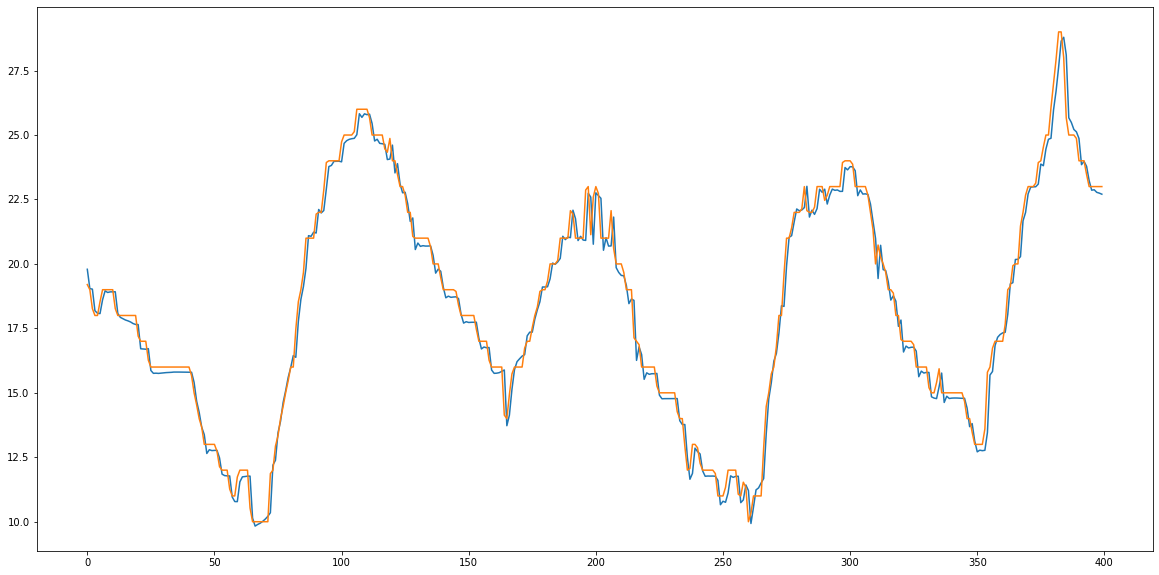

Iter:  1 train:  0.018668399861052218 val:  0.024228977535692635
Iter time:  0.710518341511488
Saving...
Iter:  2 train:  0.01831645068020624 val:  0.022885827413717277
Iter time:  0.7200515316799283
Iter:  3 train:  0.01826329927589819 val:  0.023220476661018678
Iter time:  0.7253123018890619
Iter:  4 train:  0.018313198792536824 val:  0.022984360410755696
Iter time:  0.7418766217306256
Saving...
Iter:  5 train:  0.018103097004192728 val:  0.02287855876732328
Iter time:  0.7545955395326018
Iter:  6 train:  0.01799215509450374 val:  0.023542424124460698
Iter time:  0.7339905286207795
Iter:  7 train:  0.018556938529472218 val:  0.02352406925213329
Iter time:  0.7333858115598559
Iter:  8 train:  0.018256234705746985 val:  0.02309832255648972
Iter time:  0.7282569268718362
Iter:  9 train:  0.018121380027033007 val:  0.025382427992349105
Iter time:  0.7285332009196281
Iter:  10 train:  0.01805260936050844 val:  0.02387490653801769
Iter time:  0.727426066994667
mse:  0.27588534 mae:  0.3819

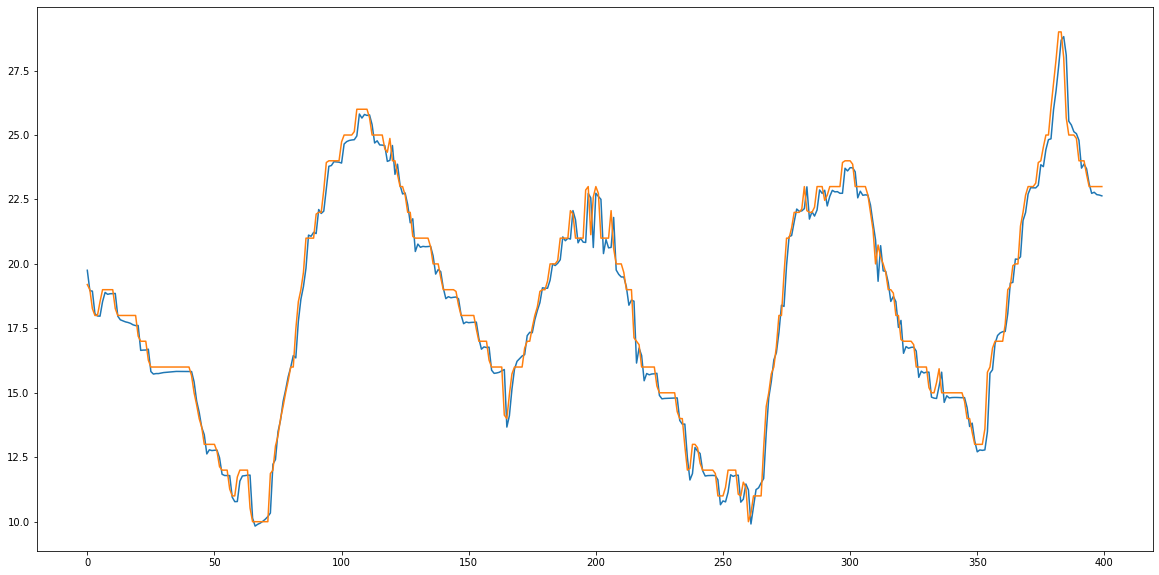

Iter:  11 train:  0.018495480764516365 val:  0.023206166194928317
Iter time:  0.7328392034396529
Iter:  12 train:  0.018147271979329943 val:  0.022958651795406217
Iter time:  0.73511653393507
Iter:  13 train:  0.018307259872233184 val:  0.02302625590465402
Iter time:  0.6392962438985705
Saving...
Iter:  14 train:  0.01811462992822566 val:  0.022855650096050645
Iter time:  0.6334969103336334
Iter:  15 train:  0.018173319017280243 val:  0.023507652396585203
Iter time:  0.6113293347880244
Iter:  16 train:  0.01882714969060743 val:  0.023388903523136172
Iter time:  0.6201416458934546
Iter:  17 train:  0.01922250408484445 val:  0.02333220652200369
Iter time:  0.6108822962269187
Iter:  18 train:  0.018221000056073938 val:  0.02430203455467918
Iter time:  0.6192238107323647
Iter:  19 train:  0.018615326570735988 val:  0.023354507073826945
Iter time:  0.6150329075753689
Iter:  20 train:  0.01836292538056219 val:  0.024543825148862528
Iter time:  0.6175750680267811
mse:  0.29156122 mae:  0.4042

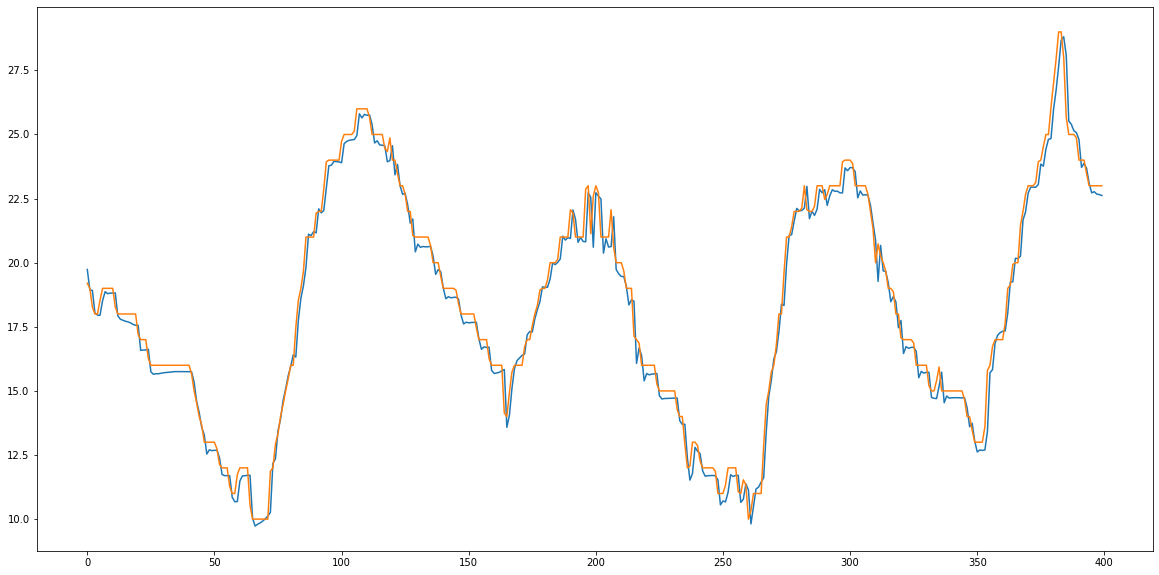

Iter:  21 train:  0.01819559606676361 val:  0.02288092068197102
Iter time:  0.6093057058751583
Iter:  22 train:  0.018185560280141663 val:  0.022999539701440194
Iter time:  0.6169934002682567
Iter:  23 train:  0.018431946283590045 val:  0.023114240114902394
Iter time:  0.6204396318644285
Iter:  24 train:  0.018992118496315595 val:  0.022882080485134574
Iter time:  0.6103405999019742
Iter:  25 train:  0.018106638993488525 val:  0.023154135916257836
Iter time:  0.6138919861987233
Iter:  26 train:  0.018102809435447932 val:  0.023054290039310203
Iter time:  0.6121559664607048
Iter:  27 train:  0.018450715683008823 val:  0.022982857278191132
Iter time:  0.6097714193165302
Iter:  28 train:  0.01817722883837288 val:  0.02339293753602738
Iter time:  0.6160291666164994
Iter:  29 train:  0.01806905194574778 val:  0.023796141570254947
Iter time:  0.613339233212173
Iter:  30 train:  0.017980281883264122 val:  0.022898942885358008
Iter time:  0.6138666467741132
mse:  0.2537909 mae:  0.33009705


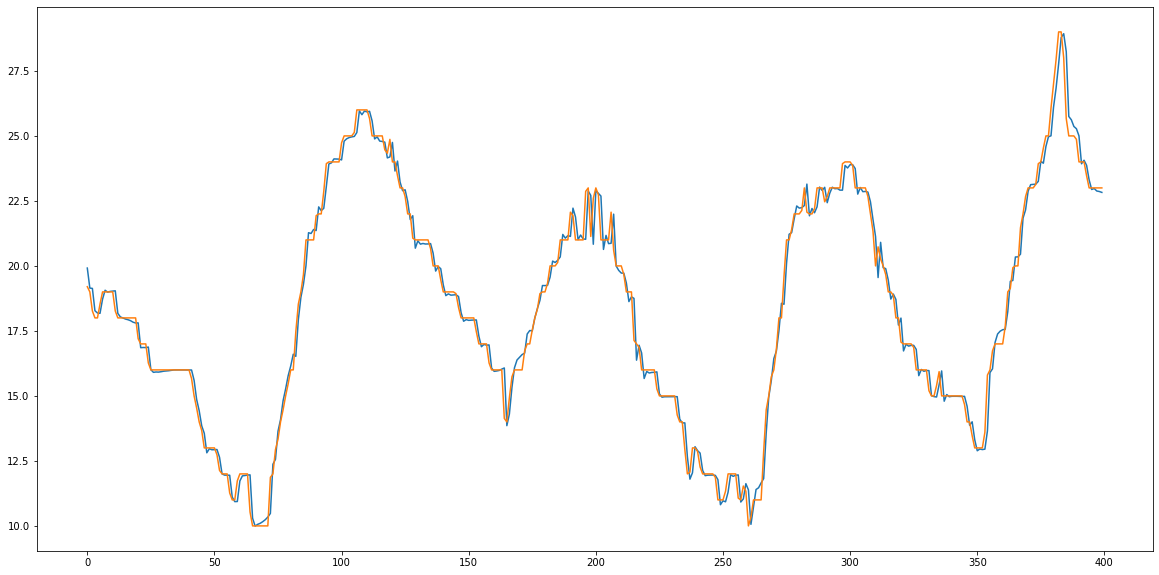

Iter:  31 train:  0.018330238800628673 val:  0.023817378692958188
Iter time:  0.6173952361568809
Iter:  32 train:  0.019109204549824673 val:  0.023560224929174648
Iter time:  0.6179903214797378
Iter:  33 train:  0.018287304543321937 val:  0.023070453648857205
Iter time:  0.6078708795830607
Iter:  34 train:  0.018484417888342725 val:  0.02287395818512345
Iter time:  0.6179219717159867
Iter:  35 train:  0.018234025866397156 val:  0.022874613083110316
Iter time:  0.6128834970295429
Iter:  36 train:  0.01837524513051979 val:  0.023592595587681835
Iter time:  0.6186495488509536
Iter:  37 train:  0.01862971805935022 val:  0.023149230435714666
Iter time:  0.616342393681407
Iter:  38 train:  0.018373423267467742 val:  0.024639950691477782
Iter time:  0.6115279830992222
Iter:  39 train:  0.018417946054594316 val:  0.022990411961094595
Iter time:  0.6163815939798951
Iter:  40 train:  0.018113314695716403 val:  0.02298056227376278
Iter time:  0.6156779238954186
mse:  0.25560334 mae:  0.3453614


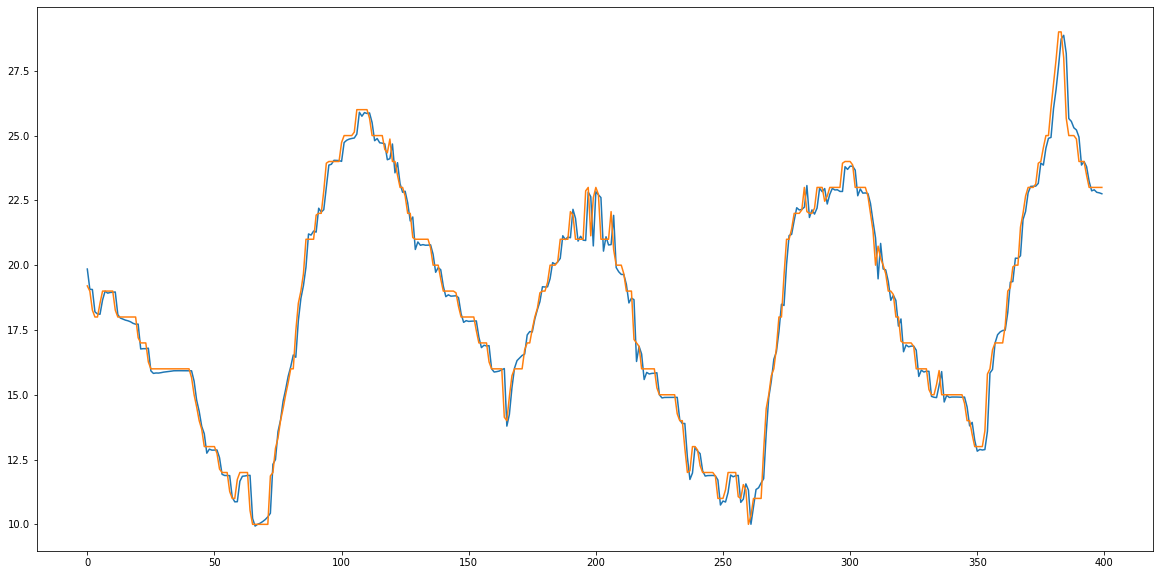

Iter:  41 train:  0.017995900698724487 val:  0.022968926287156206
Iter time:  0.6728951036930084
Iter:  42 train:  0.01795426869485684 val:  0.022933576203750347
Iter time:  0.6235145600512624
Iter:  43 train:  0.01821920836286763 val:  0.02386435018147607
Iter time:  0.6173437787219882
Iter:  44 train:  0.018479838609802252 val:  0.023375662050331807
Iter time:  0.6218452779576182
Iter:  45 train:  0.018305376065005572 val:  0.02296631338695899
Iter time:  0.6191232930868864
Iter:  46 train:  0.018133562828001226 val:  0.022983984991384897
Iter time:  0.621155290864408
Iter:  47 train:  0.018401197045005303 val:  0.02299089614188598
Iter time:  0.6168568301945925
Iter:  48 train:  0.018289867298054523 val:  0.023143777955749425
Iter time:  0.620968347415328


In [55]:
epochs = 1000
loss = nn.MSELoss()
patience = 35
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    iteration_start = time.monotonic()
    for batch_x, batch_y in train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output, alphas, betas = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "imv_lstm_sml2010.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    iteration_end = time.monotonic()
    print("Iter time: ", iteration_end - iteration_start)
    if(i % 10 == 0):
        preds = preds*(y_train_max - y_train_min) + y_train_min
        true = true*(y_train_max - y_train_min) + y_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [70]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    alphas_freeze_1 = []
    betas_freeze_1 = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output, a, b = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        alphas_freeze_1.append(a.detach().cpu().numpy())
        betas_freeze_1.append(b.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)
alphas_freeze_1 = np.concatenate(alphas_freeze_1)
betas_freeze_1 = np.concatenate(betas_freeze_1)

In [71]:
alphas_freeze_1 = alphas_freeze_1.mean(axis=0)
betas_freeze_1 = betas_freeze_1.mean(axis=0)

In [72]:
alphas_freeze_1 = alphas_freeze_1[..., 0]
betas_freeze_1 = betas_freeze_1[..., 0]

In [73]:
alphas_freeze_1 = alphas_freeze_1.transpose(1, 0)

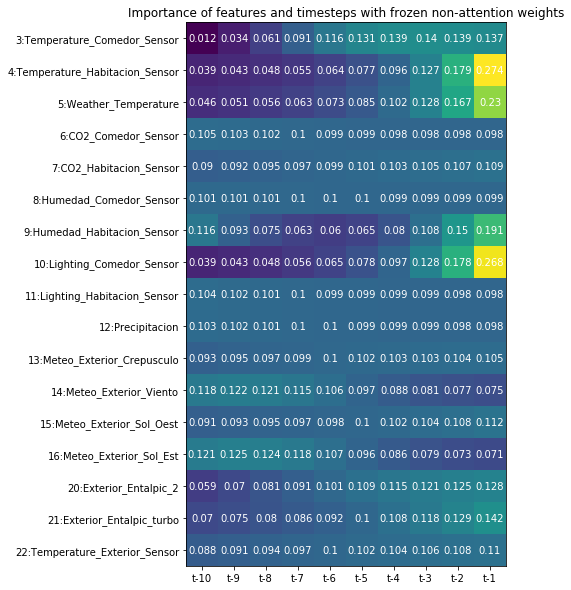

In [74]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(alphas_freeze_1)
ax.set_xticks(np.arange(X_train_t.shape[1]))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], -1, -1)])
ax.set_yticklabels(cols)
for i in range(len(cols)):
    for j in range(X_train_t.shape[1]):
        text = ax.text(j, i, round(alphas_freeze_1[i, j], 3),
                       ha="center", va="center", color="w")
ax.set_title("Importance of features and timesteps with frozen non-attention weights")
#fig.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x7f37cdd78588>,
 <a list of 17 Text xticklabel objects>)

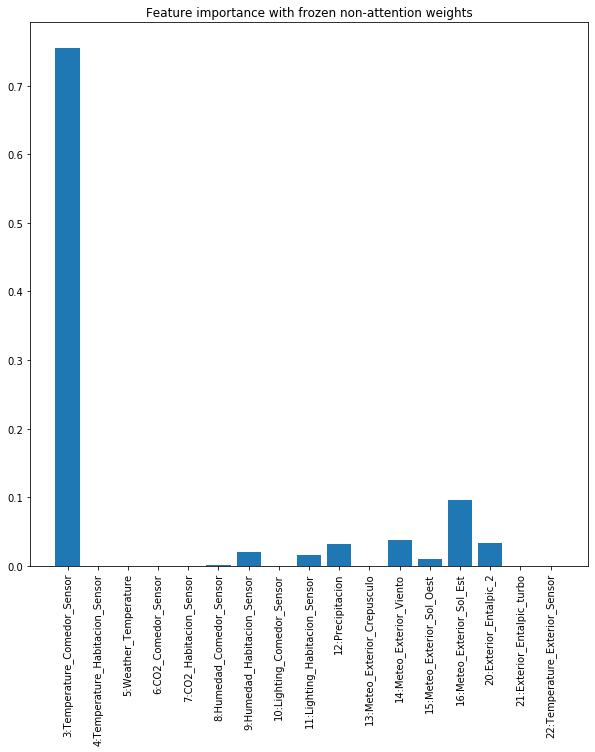

In [76]:
plt.figure(figsize=(10, 10))
plt.title("Feature importance with frozen non-attention weights")
plt.bar(range(len(cols)), betas_freeze_1)
plt.xticks(ticks=range(len(cols)), labels=cols, rotation=90)

In [77]:
# train another model

In [78]:
model = IMVTensorLSTM(X_train.shape[2], 1, 128).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [79]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

Saving...
Iter:  0 train:  0.35804554151308704 val:  0.1714399006376833
Iter time:  1.2535661989822984
mse:  14.225554 mae:  3.1104357


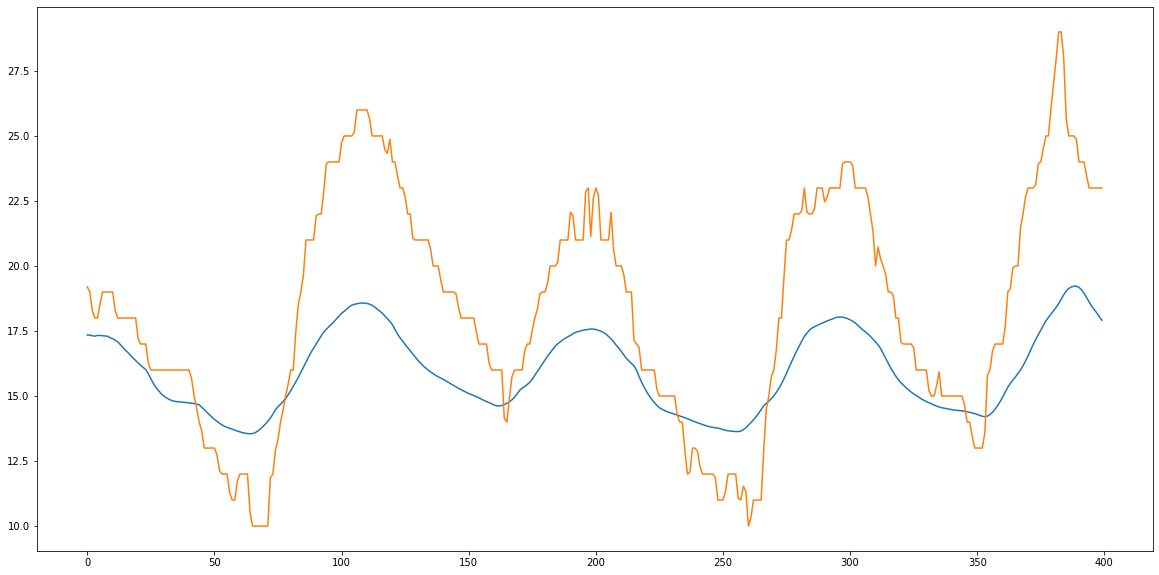

Saving...
Iter:  1 train:  0.10624056128865414 val:  0.10952227962509603
Iter time:  1.1333077158778906
Saving...
Iter:  2 train:  0.079065517408908 val:  0.07742852588537007
Iter time:  1.1346903275698423
Iter:  3 train:  0.06781476960151704 val:  0.07783748698527734
Iter time:  1.1366538861766458
Saving...
Iter:  4 train:  0.06408163158419163 val:  0.0747590491014886
Iter time:  1.155925870873034
Saving...
Iter:  5 train:  0.05896846595649608 val:  0.06624510581117034
Iter time:  1.1459078453481197
Saving...
Iter:  6 train:  0.049435380005952705 val:  0.06248883229557777
Iter time:  1.1467693513259292
Saving...
Iter:  7 train:  0.0436087486914191 val:  0.055374145087344354
Iter time:  1.146692220121622
Saving...
Iter:  8 train:  0.0401696410384786 val:  0.0452737608203583
Iter time:  1.1481786398217082
Saving...
Iter:  9 train:  0.039887397446378474 val:  0.04237610757327648
Iter time:  1.1468478571623564
Iter:  10 train:  0.036942130703143436 val:  0.04300717716284799
Iter time:  1.

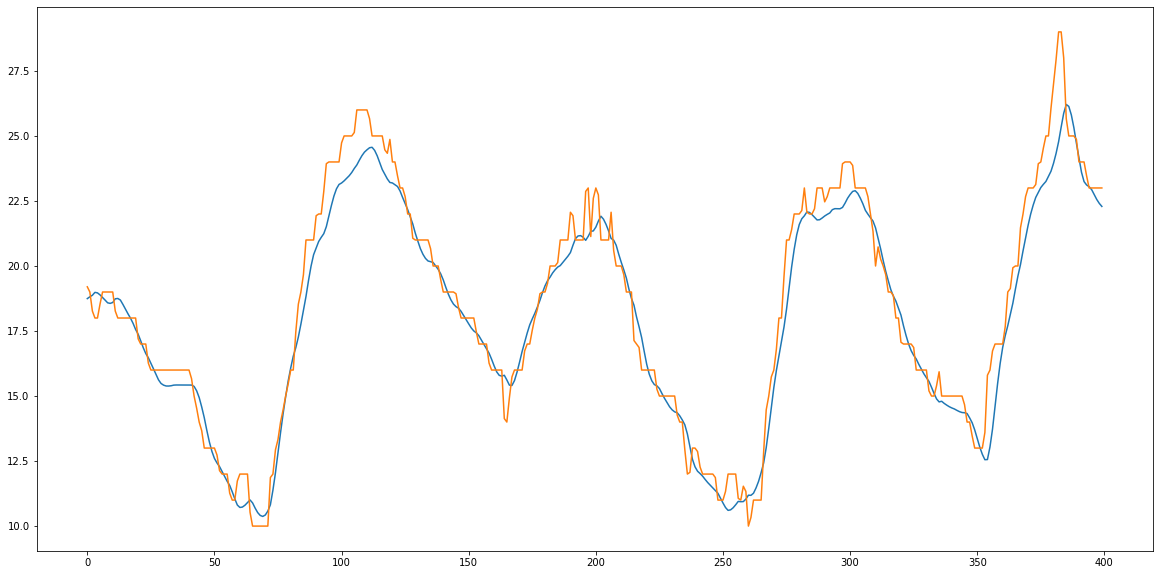

Saving...
Iter:  11 train:  0.04106160895482914 val:  0.04217013414467408
Iter time:  1.1087077800184488
Saving...
Iter:  12 train:  0.03619024775629359 val:  0.04030897160177487
Iter time:  1.1116821710020304
Saving...
Iter:  13 train:  0.034249096665003365 val:  0.03734835582824447
Iter time:  1.1098255151882768
Iter:  14 train:  0.036510014425721604 val:  0.04457527324858994
Iter time:  1.0962764583528042
Iter:  15 train:  0.03571472198120207 val:  0.039674531754347334
Iter time:  1.1200649738311768
Iter:  16 train:  0.0325420418414483 val:  0.04390876659718816
Iter time:  1.1042378414422274
Saving...
Iter:  17 train:  0.03263310499392909 val:  0.03691218008055501
Iter time:  1.1227558068931103
Saving...
Iter:  18 train:  0.03240538746688485 val:  0.03504969701808622
Iter time:  1.1305675199255347
Iter:  19 train:  0.032480113619342686 val:  0.04726052729647141
Iter time:  1.1082364097237587
Iter:  20 train:  0.03067912717199309 val:  0.035590889818529516
Iter time:  1.1330521320924

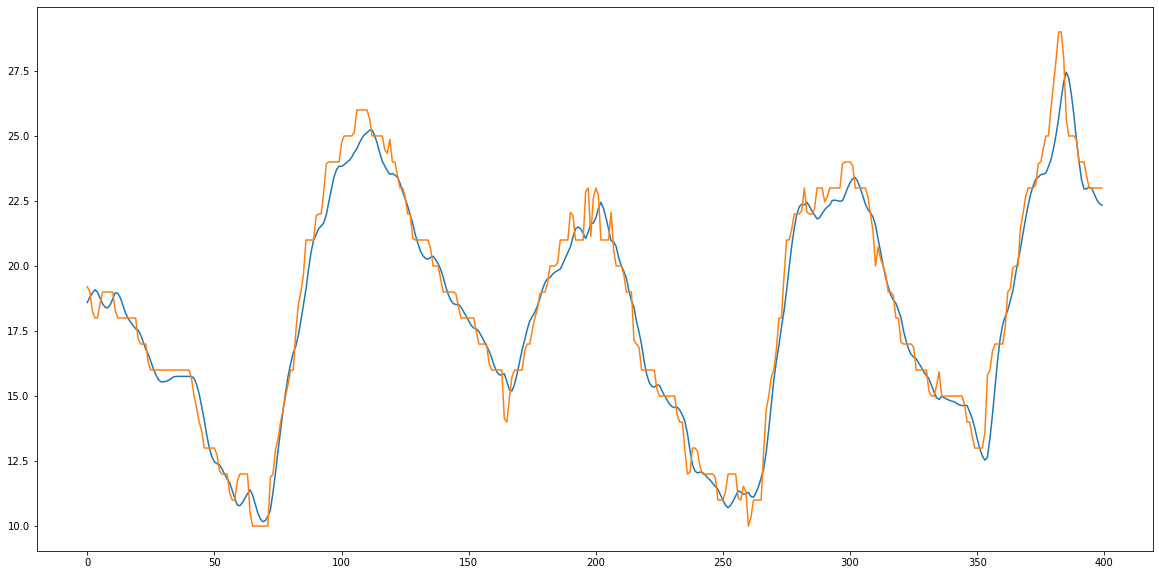

Iter:  21 train:  0.03201107342382584 val:  0.0360422739892389
Iter time:  1.2210602583363652
Iter:  22 train:  0.03015390716342348 val:  0.035170974297092816
Iter time:  1.1250968286767602
Iter:  23 train:  0.031307839857620916 val:  0.035265963941279684
Iter time:  1.1238933289423585
Iter:  24 train:  0.029578108814434914 val:  0.0355422588117755
Iter time:  1.1243141824379563
Iter:  25 train:  0.029687869630499197 val:  0.03633178505354239
Iter time:  1.1457986766472459
Saving...
Iter:  26 train:  0.031080625285022596 val:  0.03388992769839516
Iter time:  1.1702815163880587
Saving...
Iter:  27 train:  0.031098739437842266 val:  0.03370209800687923
Iter time:  1.0953110624104738
Iter:  28 train:  0.02836670048941495 val:  0.03569492031394598
Iter time:  0.8558269962668419
Saving...
Iter:  29 train:  0.029337926211012534 val:  0.03347181644314375
Iter time:  0.9516566572710872
Saving...
Iter:  30 train:  0.0281286583136634 val:  0.032659975699482424
Iter time:  0.95505565777421
mse:  

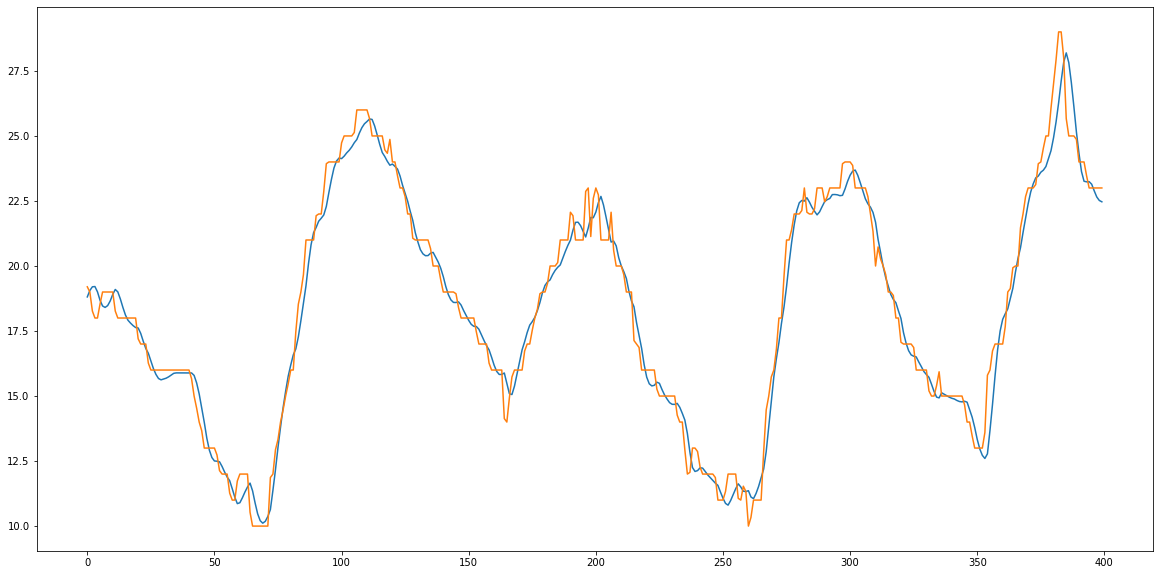

Saving...
Iter:  31 train:  0.026985396900463338 val:  0.03264567849741873
Iter time:  0.9556025126948953
Iter:  32 train:  0.026867962345184612 val:  0.037498348666628344
Iter time:  0.9354917760938406
Iter:  33 train:  0.02856677784663718 val:  0.033256474998306605
Iter time:  0.9700509076938033
Saving...
Iter:  34 train:  0.028128039125093568 val:  0.03140754504878682
Iter time:  0.9903974290937185
Iter:  35 train:  0.027418478908071746 val:  0.03596632024701411
Iter time:  0.9545904705300927
Iter:  36 train:  0.029706901077668716 val:  0.03329243177746039
Iter time:  0.9480663491412997
Saving...
Iter:  37 train:  0.026656369371682732 val:  0.031154907653199487
Iter time:  0.9661572026088834
Iter:  38 train:  0.026803803372008505 val:  0.033757956331922606
Iter time:  0.9543606229126453
Iter:  39 train:  0.026903504584929766 val:  0.03521300569181512
Iter time:  0.9657508051022887
Iter:  40 train:  0.02608572270324143 val:  0.031327639335806186
Iter time:  0.9671930838376284
mse:  0

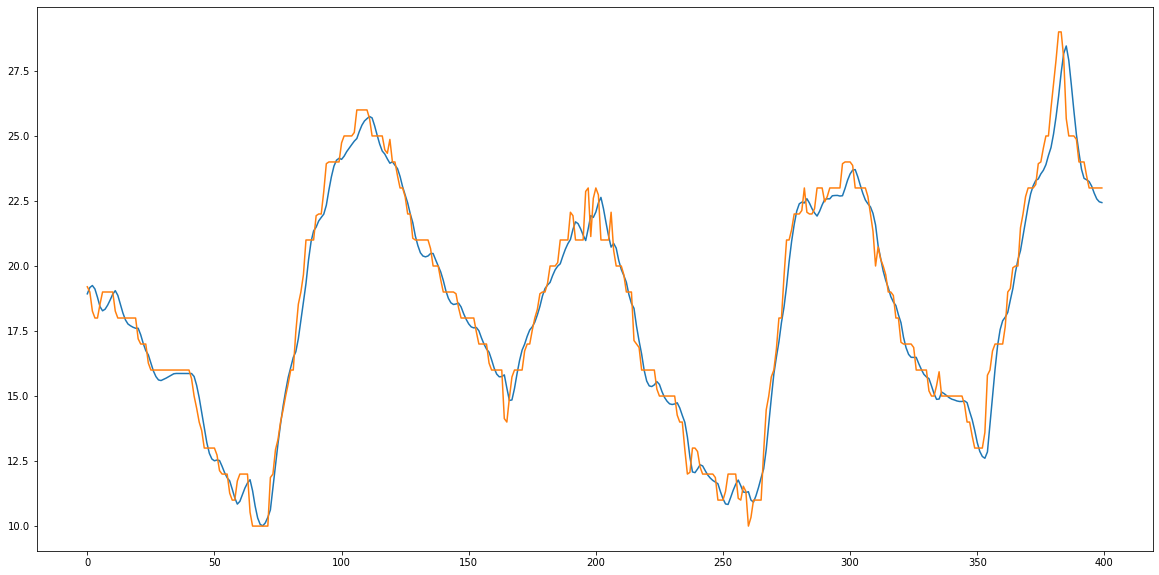

Iter:  41 train:  0.025553482885591484 val:  0.032589704962028745
Iter time:  0.9739544577896595
Saving...
Iter:  42 train:  0.025461660577595482 val:  0.030925726631167393
Iter time:  1.1525590736418962
Iter:  43 train:  0.026403971123699257 val:  0.031139046123911298
Iter time:  1.1280788788571954
Iter:  44 train:  0.02657677472747361 val:  0.03325739730542638
Iter time:  1.1247811447829008
Saving...
Iter:  45 train:  0.025060301490588164 val:  0.030364404413907725
Iter time:  1.1526498161256313
Iter:  46 train:  0.02686934600174075 val:  0.0357127770862021
Iter time:  1.129859171807766
Saving...
Iter:  47 train:  0.02586982931989492 val:  0.02978183884203647
Iter time:  1.1459335759282112
Iter:  48 train:  0.024763109436995747 val:  0.030483468028301805
Iter time:  1.123907869681716
Saving...
Iter:  49 train:  0.024983289612346308 val:  0.029411797980923447
Iter time:  1.1317930687218904
Iter:  50 train:  0.024800420009597892 val:  0.03155263584325831
Iter time:  1.1056203236803412


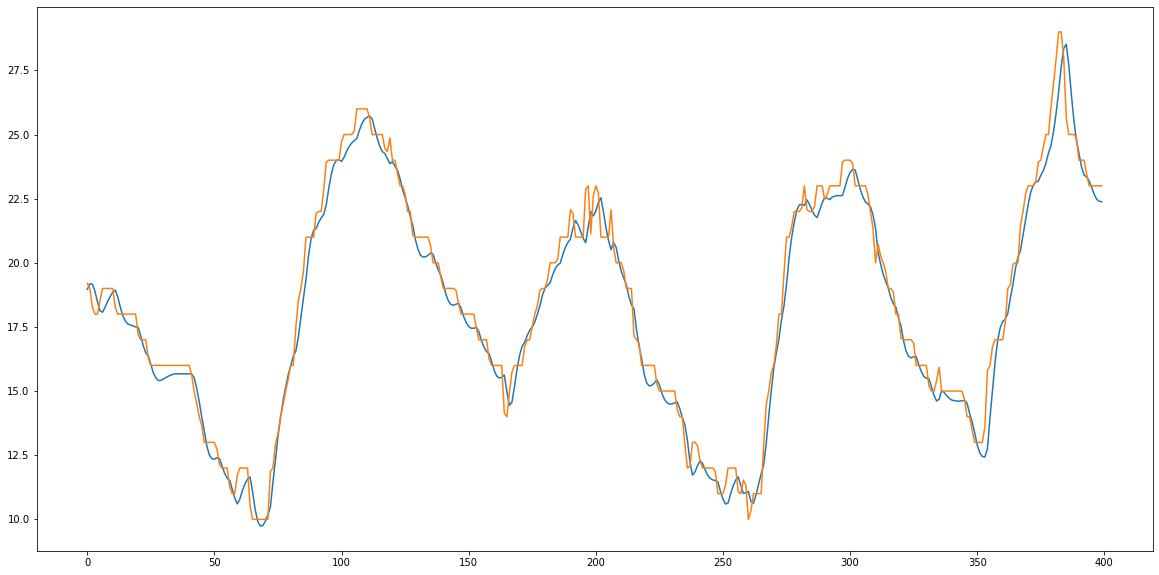

Iter:  51 train:  0.02549310002907857 val:  0.029589636490350915
Iter time:  1.1068630926311016
Iter:  52 train:  0.02425855059946266 val:  0.030190125546688706
Iter time:  1.1081764893606305
Iter:  53 train:  0.024153290275558008 val:  0.03169697744210414
Iter time:  1.1084892619401217
Saving...
Iter:  54 train:  0.024450530451303843 val:  0.028629072408236908
Iter time:  1.1433893963694572
Iter:  55 train:  0.02451935483969137 val:  0.031762865082201316
Iter time:  1.1483730282634497
Iter:  56 train:  0.02367679280638694 val:  0.028969465704958182
Iter time:  1.1207770695909858
Saving...
Iter:  57 train:  0.02308090651554667 val:  0.0285305222698422
Iter time:  1.1352787408977747
Saving...
Iter:  58 train:  0.022929227900171392 val:  0.0280266671979639
Iter time:  1.1420802809298038
Iter:  59 train:  0.023637667861274997 val:  0.029034851565046062
Iter time:  1.1185362124815583
Saving...
Iter:  60 train:  0.023595382154327126 val:  0.02774511015345031
Iter time:  1.1667765183374286
m

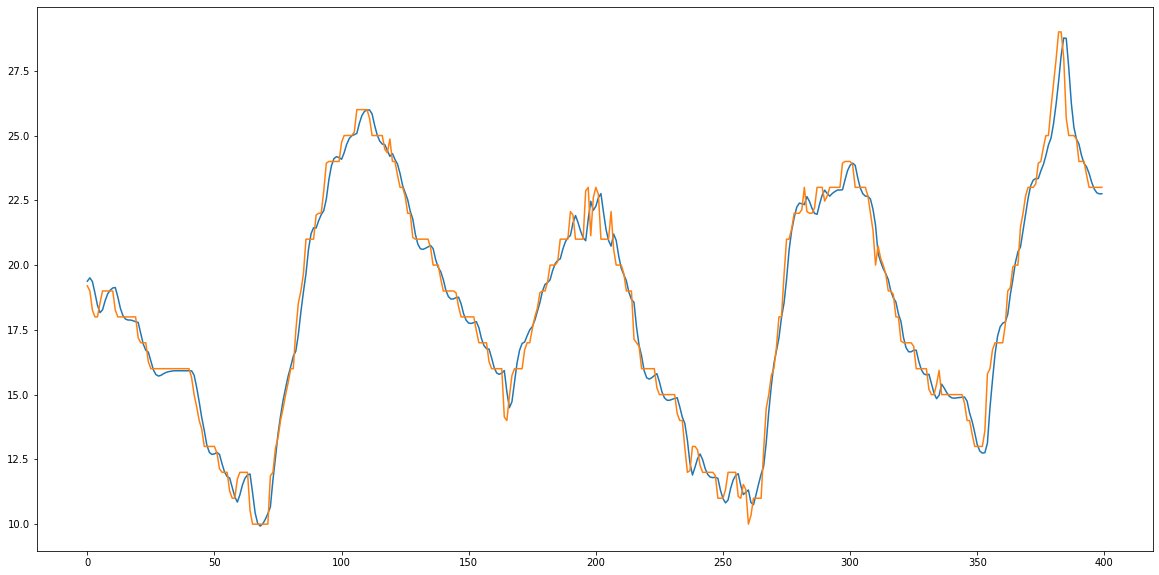

Saving...
Iter:  61 train:  0.02261839224432373 val:  0.02767428062936466
Iter time:  1.1469614943489432
Saving...
Iter:  62 train:  0.022323873931744013 val:  0.027399657519512097
Iter time:  1.1425560871139169
Iter:  63 train:  0.022208332276538952 val:  0.027625091418540085
Iter time:  1.1199685614556074
Iter:  64 train:  0.022175342796023362 val:  0.029882696251237933
Iter time:  1.1184508139267564
Iter:  65 train:  0.023230052492253052 val:  0.028243449085333126
Iter time:  1.1173738781362772
Saving...
Iter:  66 train:  0.02295737713156806 val:  0.02719599705447942
Iter time:  1.143139848485589
Saving...
Iter:  67 train:  0.022074212181585496 val:  0.026867172638594235
Iter time:  1.1434330679476261
Iter:  68 train:  0.023758499863391947 val:  0.027088316033430978
Iter time:  1.1203986257314682
Iter:  69 train:  0.022303230231919227 val:  0.027662637859856166
Iter time:  1.101482984609902
Saving...
Iter:  70 train:  0.023231050562750523 val:  0.0265678403899448
Iter time:  1.13211

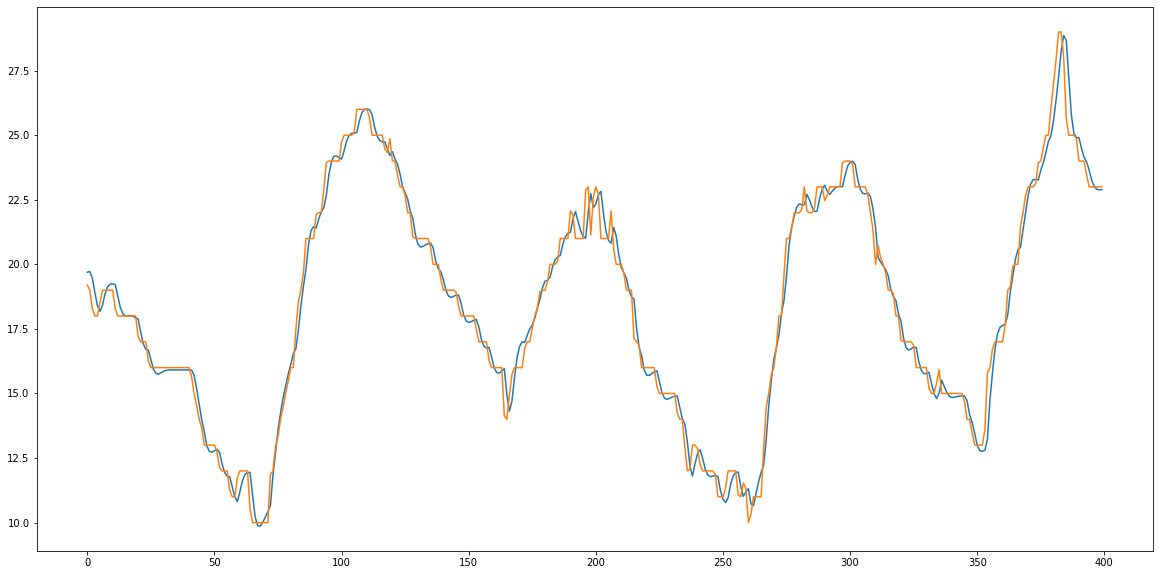

Iter:  71 train:  0.023913175230209548 val:  0.02678940102276269
Iter time:  1.1081884922459722
Iter:  72 train:  0.022077073643839276 val:  0.02695161082672399
Iter time:  1.1109096435829997
Iter:  73 train:  0.022008189209233663 val:  0.026851278671760164
Iter time:  1.1466001570224762
Iter:  74 train:  0.021898552688054736 val:  0.026801602267055292
Iter time:  1.130811370909214
Iter:  75 train:  0.021646459714896045 val:  0.028035301979348455
Iter time:  1.1111201718449593
Saving...
Iter:  76 train:  0.022019520042129856 val:  0.02613217631023234
Iter time:  1.1372338477522135
Iter:  77 train:  0.021381354673395473 val:  0.026450718914480986
Iter time:  1.1147334286943078
Iter:  78 train:  0.021805863533809765 val:  0.02693357968347305
Iter time:  1.140807474963367
Iter:  79 train:  0.02210764945297978 val:  0.026631187063452556
Iter time:  1.1410528160631657
Iter:  80 train:  0.021603998738597165 val:  0.02768985287585691
Iter time:  1.1186730787158012
mse:  0.37109625 mae:  0.434

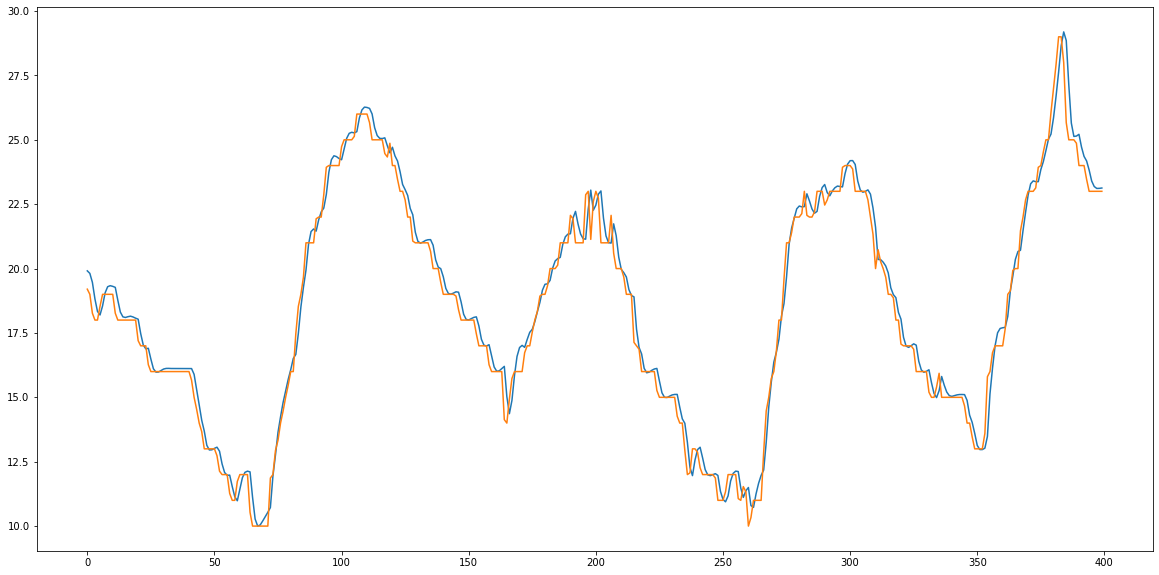

Iter:  81 train:  0.023409740056022893 val:  0.028799425217889286
Iter time:  1.1224566483870149
Iter:  82 train:  0.024075702956447013 val:  0.026159121480512377
Iter time:  1.1250515719875693
Iter:  83 train:  0.02174737027040939 val:  0.026827766696001374
Iter time:  1.1170097757130861
Saving...
Iter:  84 train:  0.021608900265812164 val:  0.025784240895959227
Iter time:  1.1461442988365889
Iter:  85 train:  0.02099762380980043 val:  0.026440293020245677
Iter time:  1.1072182161733508
Saving...
Iter:  86 train:  0.020858679662330758 val:  0.025508386530996456
Iter time:  1.1182111389935017
Iter:  87 train:  0.02221008510866368 val:  0.029668320088067267
Iter time:  1.0976509237661958
Iter:  88 train:  0.022170631322792456 val:  0.026510392121407936
Iter time:  1.0978002361953259
Iter:  89 train:  0.02120893131413126 val:  0.02612826607162722
Iter time:  1.0951764667406678
Iter:  90 train:  0.02190774954817668 val:  0.027479986648831358
Iter time:  1.1035741455852985
mse:  0.3654923 

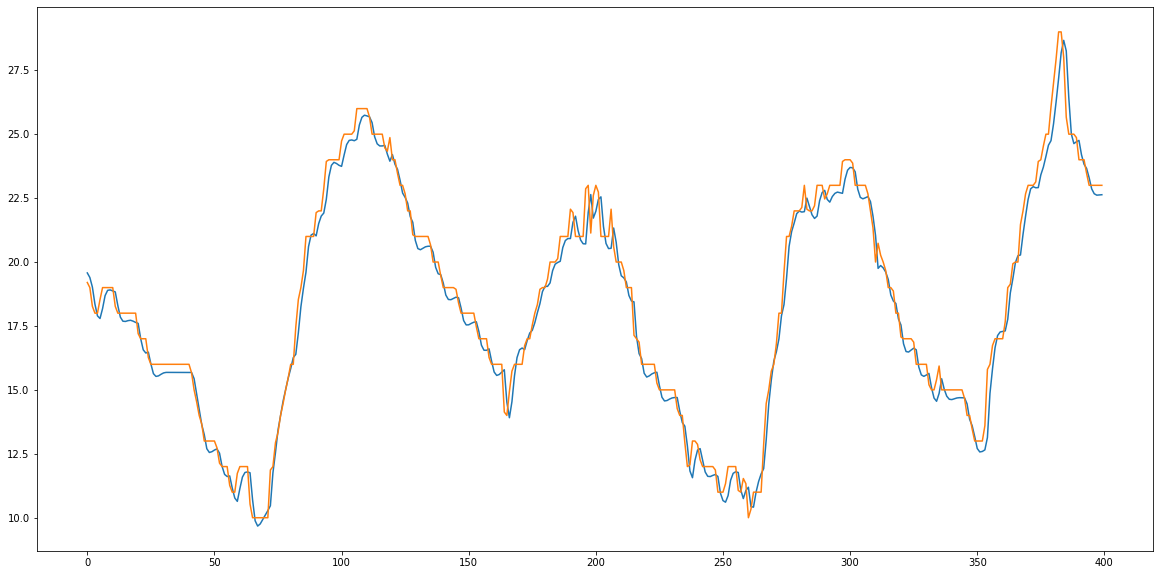

Saving...
Iter:  91 train:  0.020467526521268046 val:  0.025312874483646813
Iter time:  1.1568554369732738
Iter:  92 train:  0.02068581333891789 val:  0.026056644682172274
Iter time:  1.1045575244352221
Iter:  93 train:  0.021068844148695393 val:  0.02613381582737505
Iter time:  1.0968518806621432
Saving...
Iter:  94 train:  0.02096609529404375 val:  0.02512213185175855
Iter time:  1.1305948561057448
Iter:  95 train:  0.02100086541647283 val:  0.025160887861549325
Iter time:  1.110657887533307
Iter:  96 train:  0.020158773266124693 val:  0.025845731578394114
Iter time:  1.1320937871932983
Saving...
Iter:  97 train:  0.02094681363997089 val:  0.024833891977550065
Iter time:  1.1281294040381908
Iter:  98 train:  0.02054684654621463 val:  0.02495953126835504
Iter time:  1.098575514741242
Saving...
Iter:  99 train:  0.020360533092103287 val:  0.02471109656485644
Iter time:  1.1235372070223093
Iter:  100 train:  0.020186278094425695 val:  0.024956153532820265
Iter time:  1.098028413951397
m

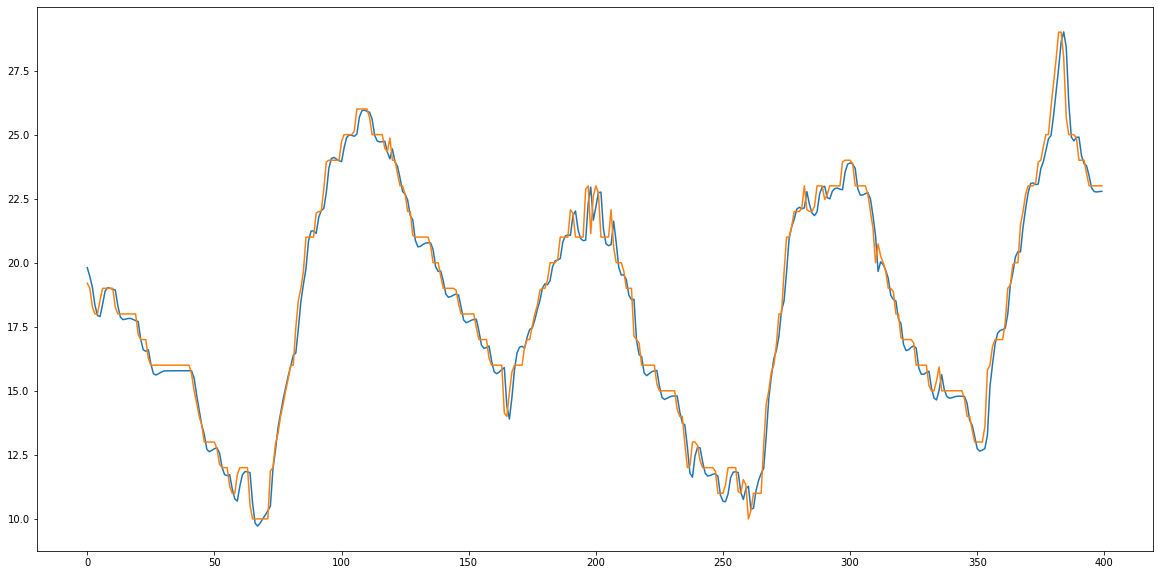

Saving...
Iter:  101 train:  0.020089751230916095 val:  0.02428567104429039
Iter time:  1.1202317206189036
Saving...
Iter:  102 train:  0.02045148766566587 val:  0.02413383409974976
Iter time:  1.1187203787267208
Iter:  103 train:  0.0208274975539347 val:  0.024688351867712156
Iter time:  1.09539142716676
Iter:  104 train:  0.020132067172574177 val:  0.02449312093467896
Iter time:  1.0949491998180747
Iter:  105 train:  0.01967080630050513 val:  0.02445131540077319
Iter time:  1.1009669844061136
Iter:  106 train:  0.019929947973915275 val:  0.0257275911606851
Iter time:  0.8695203987881541
Saving...
Iter:  107 train:  0.020413104439951767 val:  0.023902111996510458
Iter time:  0.957008303143084
Iter:  108 train:  0.019951088582793226 val:  0.02442106118023849
Iter time:  0.9410019312053919
Iter:  109 train:  0.01956993061720713 val:  0.023957110348702605
Iter time:  0.9356821151450276
Iter:  110 train:  0.019500767728873398 val:  0.024625800059393563
Iter time:  0.9357812935486436
mse: 

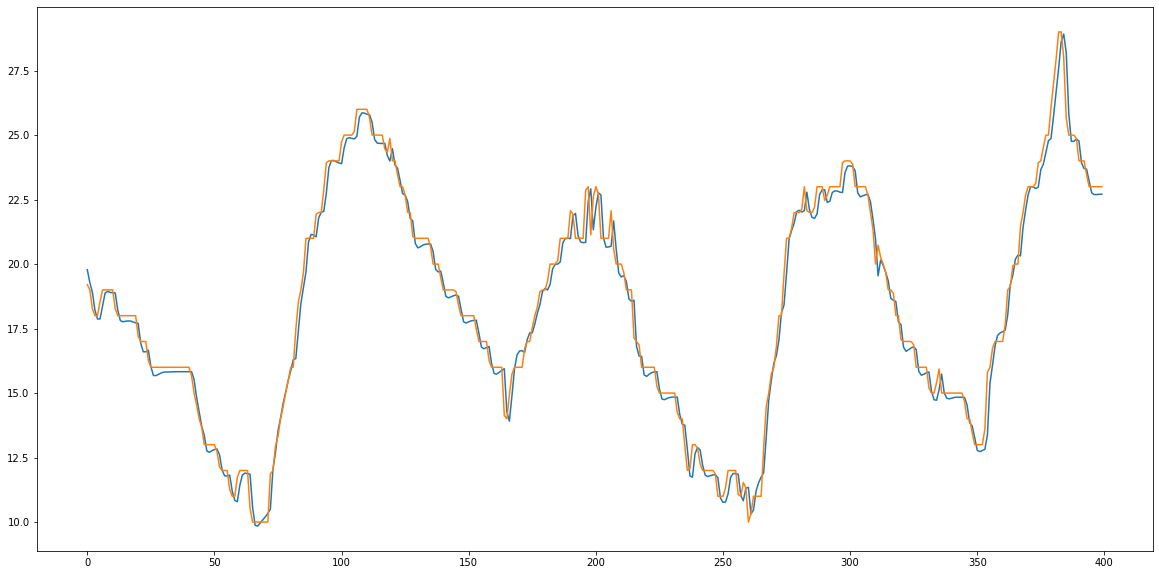

Iter:  111 train:  0.019395944217629284 val:  0.02473635168258925
Iter time:  0.9388725506141782
Iter:  112 train:  0.01941400729223213 val:  0.026287069634831888
Iter time:  0.9356249906122684
Iter:  113 train:  0.019811486689444713 val:  0.02402424549279184
Iter time:  0.9359511733055115
Iter:  114 train:  0.019476366121179638 val:  0.025137278899596188
Iter time:  0.9360584244132042
Iter:  115 train:  0.01930295743405944 val:  0.02440109871954679
Iter time:  0.9359427578747272
Iter:  116 train:  0.019604711126377412 val:  0.024750869951678932
Iter time:  0.9356128890067339
Iter:  117 train:  0.02026286174801769 val:  0.02648519616696616
Iter time:  0.9365040231496096
Iter:  118 train:  0.021029788915067398 val:  0.025403456196776978
Iter time:  0.9356890171766281
Iter:  119 train:  0.020229928763509 val:  0.023915223302835974
Iter time:  0.9359300276264548
Saving...
Iter:  120 train:  0.019371537213868004 val:  0.02331072525176705
Iter time:  0.9571392238140106
mse:  0.26300064 mae:

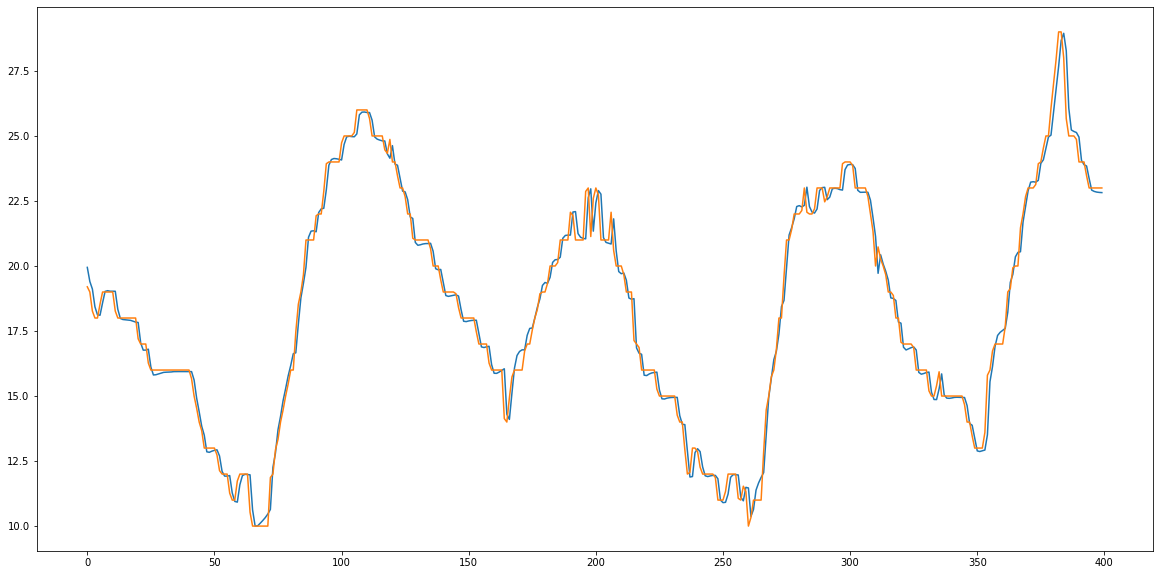

Iter:  121 train:  0.01986415889775516 val:  0.025991800865173376
Iter time:  0.9324747668579221
Iter:  122 train:  0.020060012645618533 val:  0.023350529140064958
Iter time:  0.9356615142896771
Iter:  123 train:  0.019231528375352736 val:  0.02366218947878388
Iter time:  0.9362203851342201
Iter:  124 train:  0.01951376835953237 val:  0.02351630552073929
Iter time:  0.9357077172026038
Iter:  125 train:  0.01914918155119798 val:  0.026588546555687098
Iter time:  0.9381588641554117
Iter:  126 train:  0.019590560828675826 val:  0.025521370403037938
Iter time:  0.9950997810810804
Iter:  127 train:  0.018926041672953416 val:  0.023540871270564073
Iter time:  1.1066117342561483
Saving...
Iter:  128 train:  0.019008817836349338 val:  0.0232233025859532
Iter time:  1.1173191675916314
Iter:  129 train:  0.02081723655165842 val:  0.024071498756109734
Iter time:  1.0731627233326435
Iter:  130 train:  0.01918880699475754 val:  0.02392038985251149
Iter time:  1.0701825972646475
mse:  0.27693745 mae

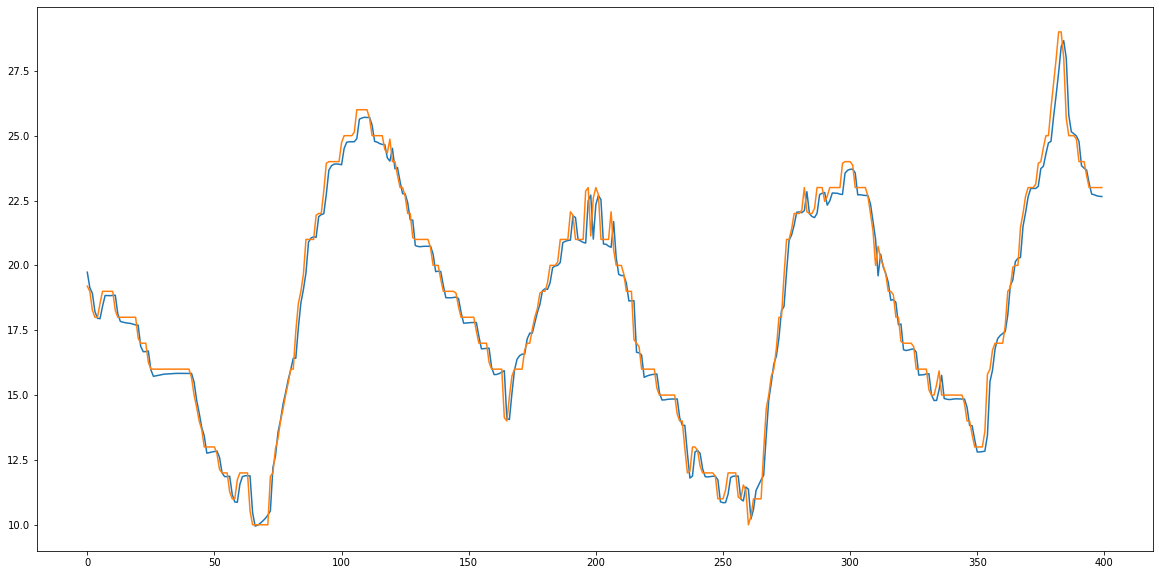

Iter:  131 train:  0.01869152685527468 val:  0.023692019046616553
Iter time:  1.06175550352782
Saving...
Iter:  132 train:  0.019440305498206304 val:  0.023054544841547325
Iter time:  1.080862944945693
Iter:  133 train:  0.021136344241502094 val:  0.027381123818583725
Iter time:  1.0586549313738942
Iter:  134 train:  0.0193877479306344 val:  0.023468993207595802
Iter time:  1.0385096054524183
Iter:  135 train:  0.018994310678958463 val:  0.02521355665203246
Iter time:  0.9016423439607024
Iter:  136 train:  0.019462039728628373 val:  0.025194890181380554
Iter time:  1.073464029468596
Iter:  137 train:  0.019140439194825946 val:  0.02331625692288102
Iter time:  1.0768413105979562
Iter:  138 train:  0.018844530364888243 val:  0.0231159237620636
Iter time:  0.9073843834921718
Iter:  139 train:  0.019787120568340824 val:  0.023747083406820857
Iter time:  0.9001369085162878
Saving...
Iter:  140 train:  0.01857012986003962 val:  0.023047321424363203
Iter time:  0.9171216208487749
mse:  0.2570

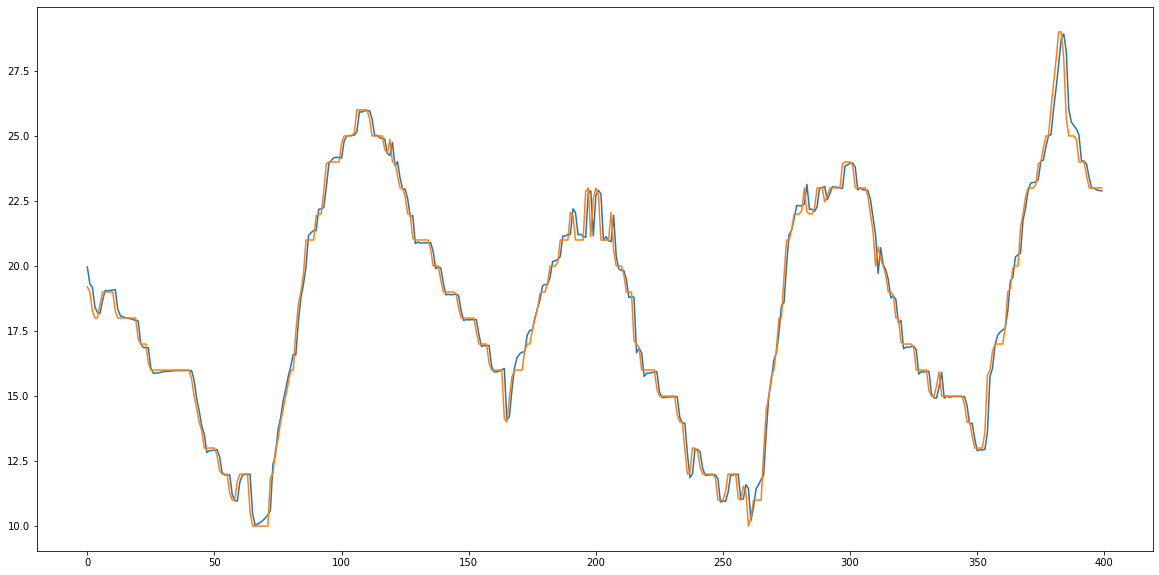

Iter:  141 train:  0.018734960619883168 val:  0.02355543960173985
Iter time:  0.9019276620820165
Iter:  142 train:  0.018570556126634892 val:  0.023164135038638598
Iter time:  0.9001063760370016
Iter:  143 train:  0.018714972180610804 val:  0.023078124027923686
Iter time:  0.8981249192729592
Saving...
Iter:  144 train:  0.01855460356128123 val:  0.02280701468441009
Iter time:  0.9212244302034378
Iter:  145 train:  0.019733936205147008 val:  0.023805953873820358
Iter time:  0.9009297015145421
Iter:  146 train:  0.018603855423774008 val:  0.023926575413972407
Iter time:  0.8992237271741033
Iter:  147 train:  0.0185024156348932 val:  0.0229258939222244
Iter time:  0.9001582823693752
Saving...
Iter:  148 train:  0.0182282433685678 val:  0.022725282006663388
Iter time:  0.9189074011519551
Iter:  149 train:  0.018170597273209188 val:  0.02291018727894769
Iter time:  0.8986048437654972
Iter:  150 train:  0.018344562242526084 val:  0.023403725577796523
Iter time:  0.9004616439342499
mse:  0.26

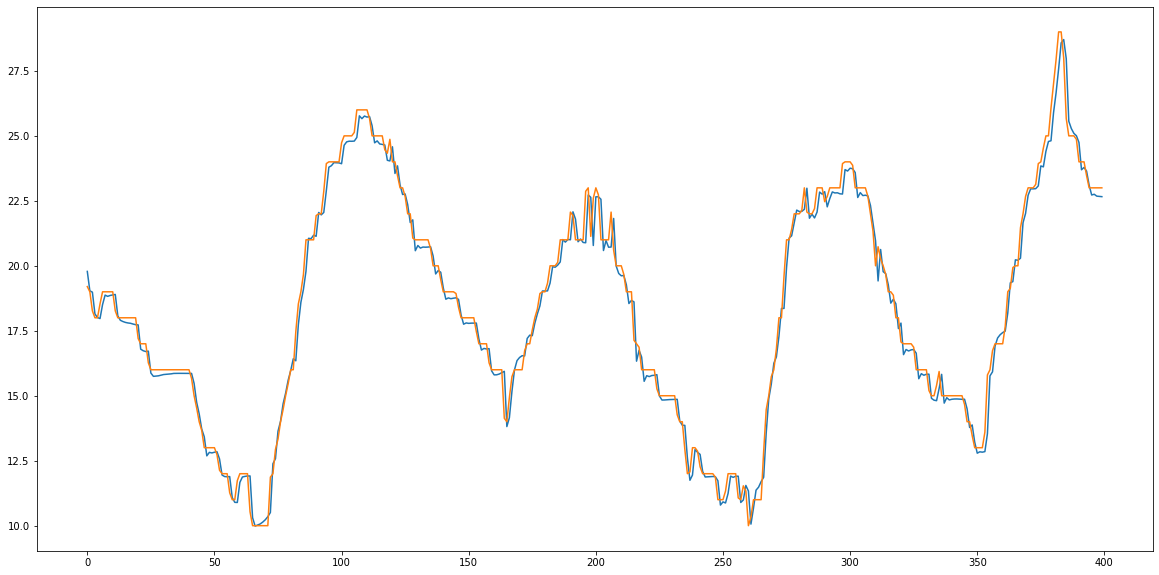

Iter:  151 train:  0.018380271566654293 val:  0.023219549851194943
Iter time:  0.9005608391016722
Iter:  152 train:  0.018689243830656434 val:  0.023492422324397043
Iter time:  0.8969137892127037
Iter:  153 train:  0.01821723390827163 val:  0.02274867404899519
Iter time:  0.8990931315347552
Iter:  154 train:  0.018680247634619822 val:  0.02305303759942274
Iter time:  0.8989453315734863
Iter:  155 train:  0.018811311345142516 val:  0.025347491453249098
Iter time:  0.8983606770634651
Iter:  156 train:  0.018354191163564168 val:  0.02298392897172473
Iter time:  0.8999735014513135
Iter:  157 train:  0.019062224407577745 val:  0.02496622344507948
Iter time:  0.8992614625021815
Iter:  158 train:  0.020001933012084472 val:  0.023353598145079677
Iter time:  0.8983714897185564
Iter:  159 train:  0.018564878977932554 val:  0.02292903915882632
Iter time:  0.8997813947498798
Iter:  160 train:  0.018367758188932437 val:  0.022800700323638633
Iter time:  1.063721988350153
mse:  0.25161797 mae:  0.33

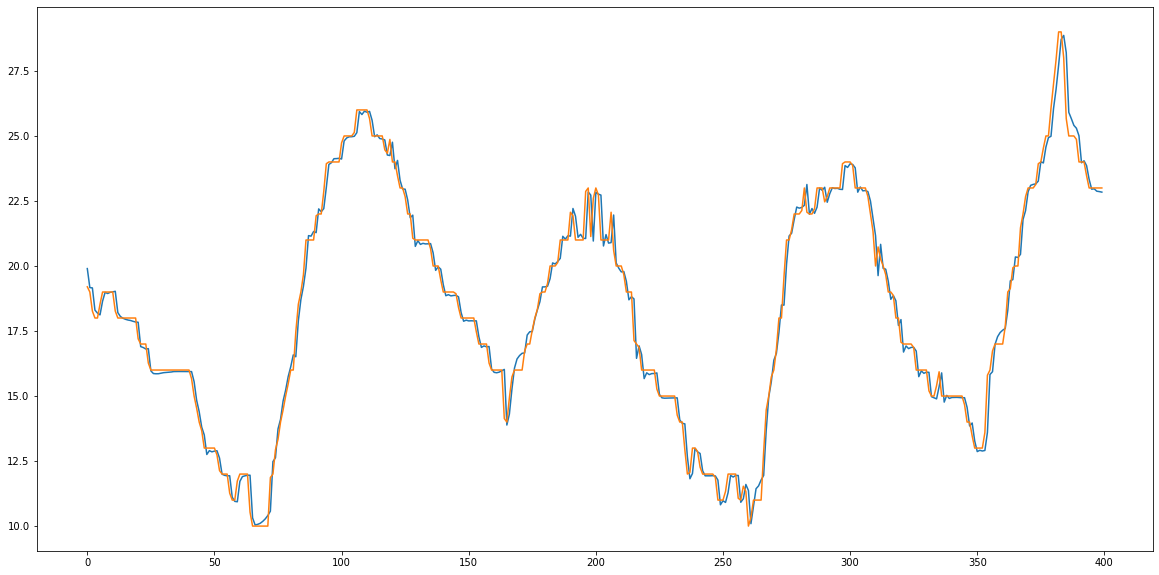

Iter:  161 train:  0.018549237764347432 val:  0.024345395988672285
Iter time:  1.0636803098022938
Iter:  162 train:  0.018679229625495435 val:  0.022846201121011392
Iter time:  1.072850144468248
Iter:  163 train:  0.018361432093145676 val:  0.02383194417911012
Iter time:  1.0725934393703938
Iter:  164 train:  0.018288124266182756 val:  0.02297012938846897
Iter time:  1.0766104636713862
Iter:  165 train:  0.01815221002186512 val:  0.023382916170349894
Iter time:  1.0453429082408547
Iter:  166 train:  0.018428339114068607 val:  0.02315929249947739
Iter time:  1.0404881918802857
Iter:  167 train:  0.018224302441666472 val:  0.023023919112951433
Iter time:  1.0389002915471792
Iter:  168 train:  0.017885245136536918 val:  0.022985277761595407
Iter time:  1.096418653614819
Iter:  169 train:  0.017899655061759313 val:  0.023322039810584456
Iter time:  0.9527422012761235
Iter:  170 train:  0.0180374180148311 val:  0.022776116737827482
Iter time:  1.0511770630255342
mse:  0.25107566 mae:  0.330

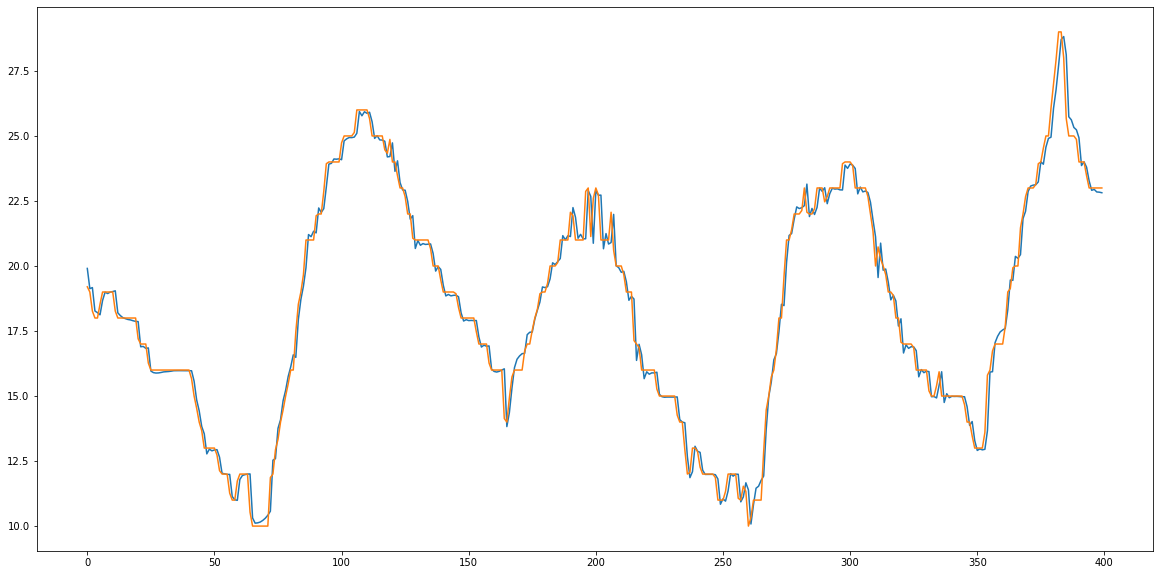

Iter:  171 train:  0.018585153376736108 val:  0.025487905304061816
Iter time:  1.042378943413496
Iter:  172 train:  0.018548547830693485 val:  0.026082256012442736
Iter time:  1.0478599797934294
Iter:  173 train:  0.01927971041230015 val:  0.023057257103989225
Iter time:  1.0440672123804688
Iter:  174 train:  0.018338385894225057 val:  0.022809086043651665
Iter time:  1.0425409963354468
Iter:  175 train:  0.01863332957832448 val:  0.023325470864255675
Iter time:  1.0412358101457357
Iter:  176 train:  0.018927972886725368 val:  0.022889801273399627
Iter time:  1.0543306106701493
Iter:  177 train:  0.018281563597006487 val:  0.023226452257329076
Iter time:  1.0447910940274596
Iter:  178 train:  0.018019067294572106 val:  0.022787460157532996
Iter time:  1.0436043674126267
Iter:  179 train:  0.01794707047641003 val:  0.022990939181935538
Iter time:  1.0543351788073778
Iter:  180 train:  0.018300459164570983 val:  0.02283525628921499
Iter time:  1.0428262455388904
mse:  0.25238124 mae:  0.

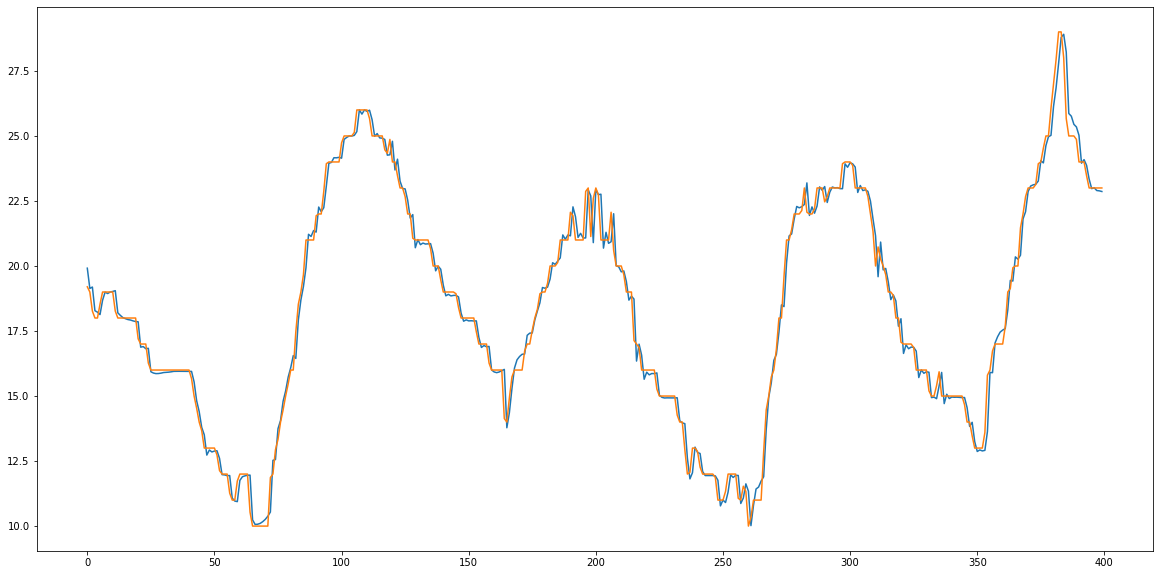

Iter:  181 train:  0.01862996780351278 val:  0.023079329810141533
Iter time:  1.0573543198406696
Iter:  182 train:  0.01803890388608719 val:  0.023077873622478255
Iter time:  1.0538873374462128


In [80]:
epochs = 1000
loss = nn.MSELoss()
patience = 35
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    iteration_start = time.monotonic()
    for batch_x, batch_y in train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output, alphas, betas = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "imv_lstm_sml2010.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    iteration_end = time.monotonic()
    print("Iter time: ", iteration_end - iteration_start)
    if(i % 10 == 0):
        preds = preds*(y_train_max - y_train_min) + y_train_min
        true = true*(y_train_max - y_train_min) + y_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [81]:
# freeze layers

In [82]:
for p in model.named_parameters():
    if p[0] not in attention_layers:
        p[1].requires_grad = False

In [83]:
# train attention weights of second model

In [84]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

Saving...
Iter:  0 train:  0.02108897252267183 val:  0.02298509168091014
Iter time:  0.8225483680143952
mse:  0.25570416 mae:  0.33763686


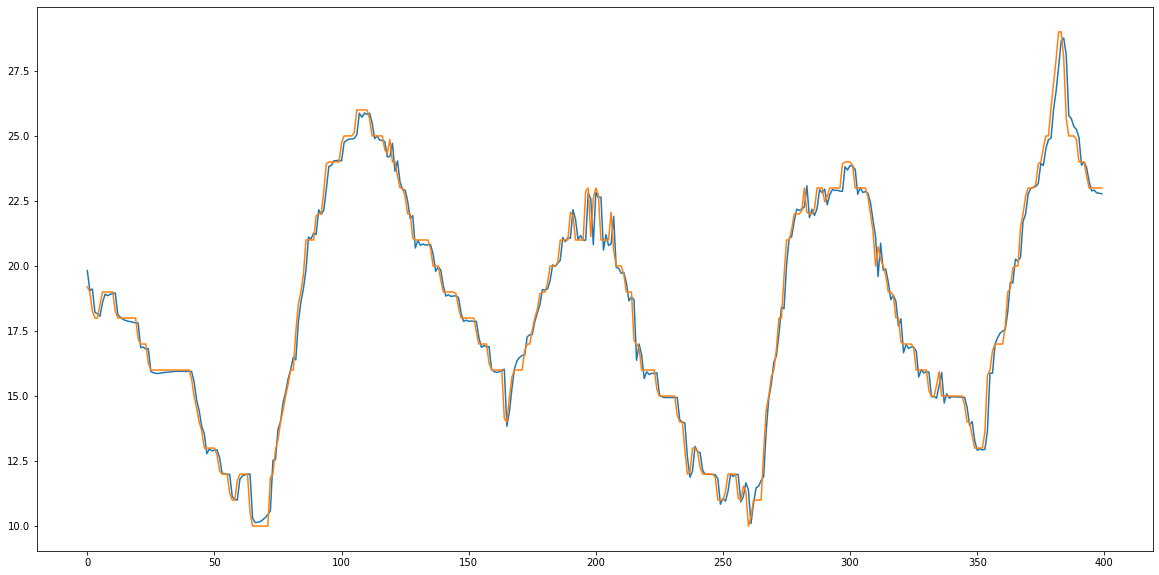

Saving...
Iter:  1 train:  0.018034319314896123 val:  0.022871055908399853
Iter time:  0.8587056770920753
Saving...
Iter:  2 train:  0.01804181654921012 val:  0.02279346408322113
Iter time:  0.7641988163813949
Iter:  3 train:  0.017962898340153747 val:  0.023213750609057462
Iter time:  0.7400013152509928
Iter:  4 train:  0.017887123774259578 val:  0.02284328787717167
Iter time:  0.7469513323158026
Iter:  5 train:  0.01809399673059732 val:  0.022879766111675862
Iter time:  0.7463802779093385
Iter:  6 train:  0.018276090495955438 val:  0.022827280115573948
Iter time:  0.7069324441254139
Iter:  7 train:  0.01818409330488631 val:  0.022939424250857782
Iter time:  0.7337513137608767
Iter:  8 train:  0.01792264963142759 val:  0.023024742664685065
Iter time:  0.7329604923725128
Iter:  9 train:  0.018001158070064728 val:  0.023200893483441367
Iter time:  0.7454311111941934
Iter:  10 train:  0.018147523799352642 val:  0.023049218858727214
Iter time:  0.7430020608007908
mse:  0.25713292 mae:  0.

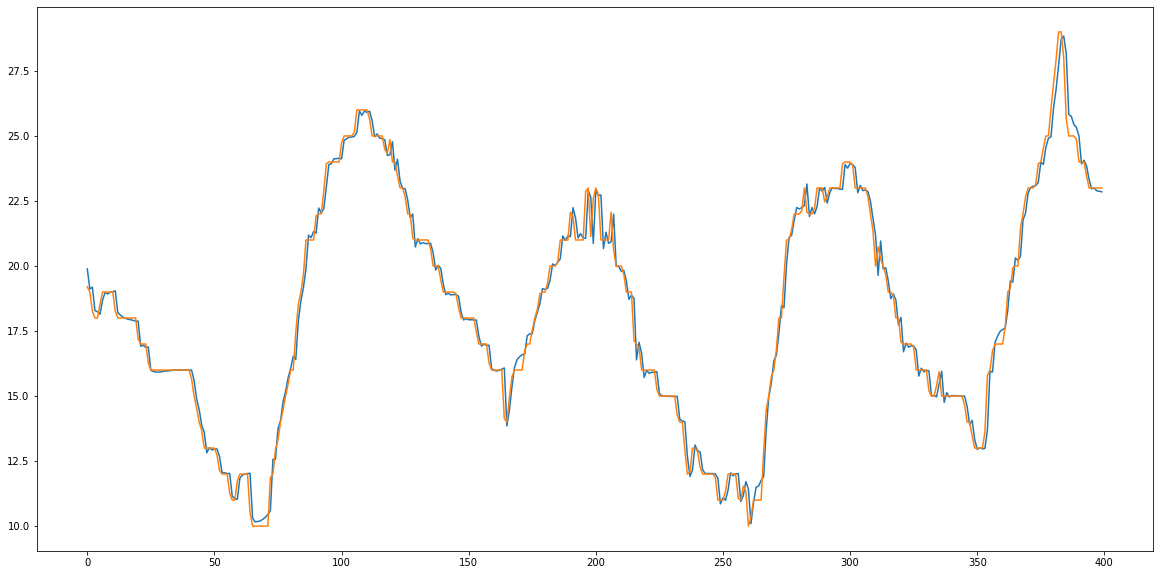

Iter:  11 train:  0.018082468636018898 val:  0.022855186888195992
Iter time:  0.7387914378196001
Saving...
Iter:  12 train:  0.017952785694932957 val:  0.02278860346596964
Iter time:  0.7595867188647389
Iter:  13 train:  0.01795973000915561 val:  0.02335421307409158
Iter time:  0.7140899877995253
Iter:  14 train:  0.017991433669937284 val:  0.022831506058205768
Iter time:  0.7185518704354763
Iter:  15 train:  0.018428400919319264 val:  0.02304867034320213
Iter time:  0.7386951940134168
Iter:  16 train:  0.018702213730080155 val:  0.023558888400788503
Iter time:  0.7359930882230401
Iter:  17 train:  0.018447315216392122 val:  0.023103244187491222
Iter time:  0.7332730321213603
Iter:  18 train:  0.018378461886224724 val:  0.02365237718764067
Iter time:  0.7424935540184379
Iter:  19 train:  0.018187976088555748 val:  0.023130246071583205
Iter time:  0.7270662672817707
Saving...
Iter:  20 train:  0.018376671194483118 val:  0.022768518049851597
Iter time:  0.760590516962111
mse:  0.2509082 

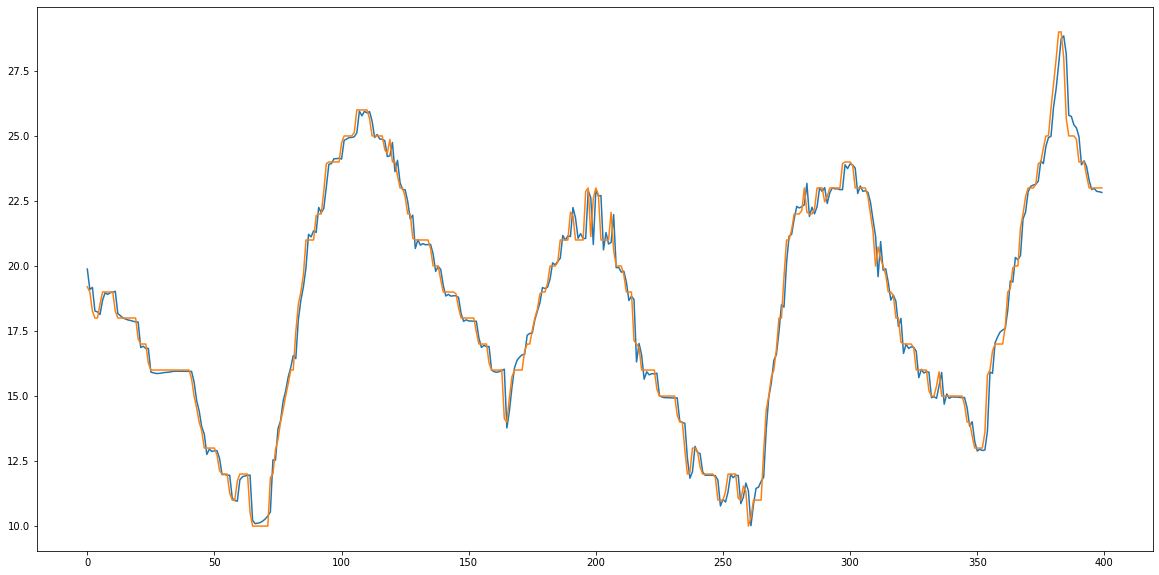

Saving...
Iter:  21 train:  0.0178378860287164 val:  0.022722197713286305
Iter time:  0.7301409868523479
Iter:  22 train:  0.01787205996218237 val:  0.022840538075839217
Iter time:  0.7360193682834506
Iter:  23 train:  0.017974567382937984 val:  0.02286086524810908
Iter time:  0.7283358369022608
Iter:  24 train:  0.018317922155495197 val:  0.022834346778642583
Iter time:  0.7248357683420181
Iter:  25 train:  0.018535532069330028 val:  0.02390883984515273
Iter time:  0.7170696537941694
Iter:  26 train:  0.018671930174446686 val:  0.022813365059284507
Iter time:  0.7332958206534386
Iter:  27 train:  0.018101349028431937 val:  0.023107856552940464
Iter time:  0.732156346552074
Iter:  28 train:  0.018063745721945496 val:  0.022780698752242142
Iter time:  0.6993397828191519
Iter:  29 train:  0.01802359361058978 val:  0.023079416165620547
Iter time:  0.6729798512533307
Iter:  30 train:  0.017797131255665986 val:  0.02283838291432017
Iter time:  0.7318653138354421
mse:  0.2524503 mae:  0.3459

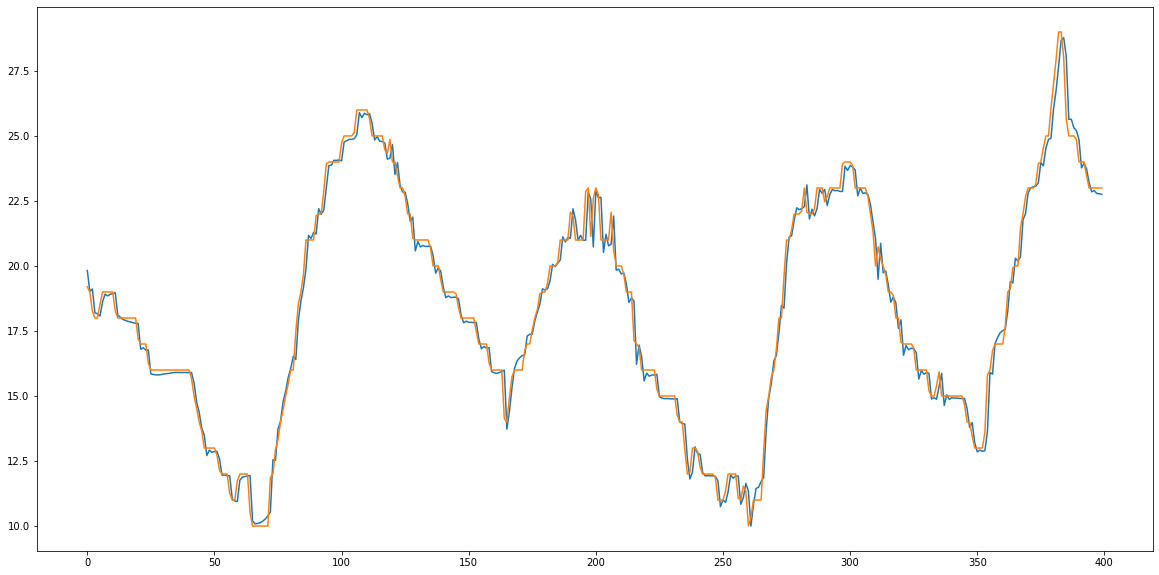

Iter:  31 train:  0.01791974196974919 val:  0.02284225637096875
Iter time:  0.7349104573950171
Iter:  32 train:  0.018034127212736843 val:  0.02288694749673241
Iter time:  0.7291393680498004
Iter:  33 train:  0.018058798400376302 val:  0.022949094467638195
Iter time:  0.7375903315842152
Iter:  34 train:  0.01785816593436765 val:  0.022745523730097306
Iter time:  0.7420260375365615
Iter:  35 train:  0.017997141798721222 val:  0.02290576015793693
Iter time:  0.7401095069944859
Iter:  36 train:  0.018230570538108684 val:  0.022873753385696794
Iter time:  0.7299686567857862
Iter:  37 train:  0.018397771688376658 val:  0.023212243272920846
Iter time:  0.7208839263767004
Iter:  38 train:  0.018005081454559646 val:  0.022930744628485288
Iter time:  0.7366148950532079
Iter:  39 train:  0.018064052640562482 val:  0.024134922166075722
Iter time:  0.7410737937316298
Iter:  40 train:  0.01835229570144635 val:  0.0234481686907147
Iter time:  0.6912006009370089
mse:  0.26611114 mae:  0.3745462


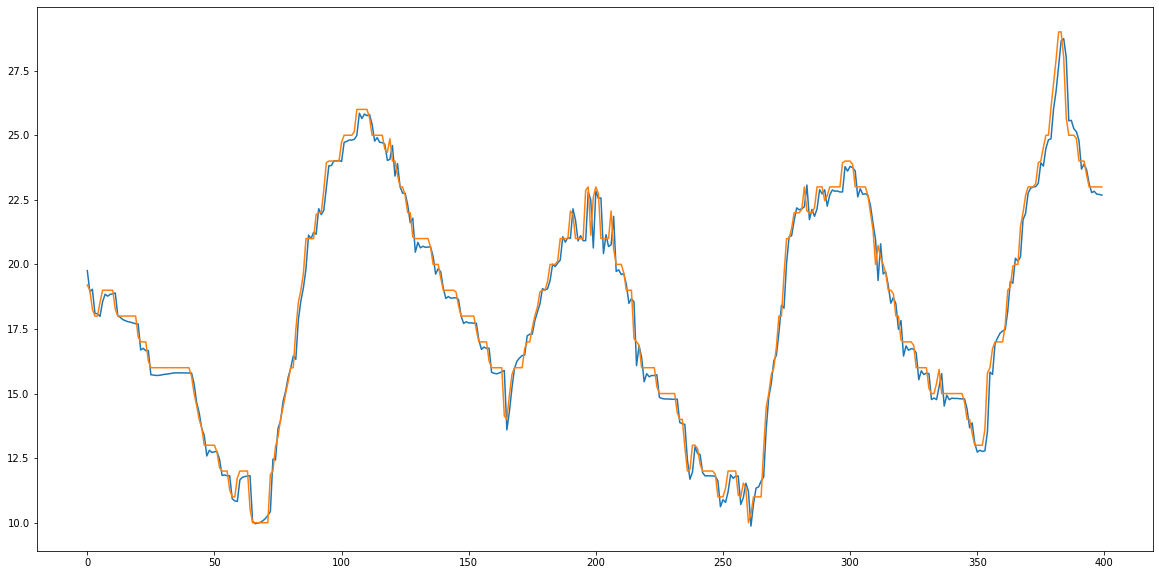

Iter:  41 train:  0.018512416302960126 val:  0.023132895510420554
Iter time:  0.7299434831365943
Iter:  42 train:  0.018201190156086313 val:  0.02291511680318349
Iter time:  0.7389486692845821
Iter:  43 train:  0.018266511424072412 val:  0.023088481189282997
Iter time:  0.7347684623673558
Iter:  44 train:  0.018136260255990928 val:  0.022746274450011168
Iter time:  0.731128765270114
Iter:  45 train:  0.01807099628340504 val:  0.022820756598725147
Iter time:  0.7311141323298216
Iter:  46 train:  0.018235295075354138 val:  0.023046186808640026
Iter time:  0.7347465353086591
Iter:  47 train:  0.01806567234375153 val:  0.02381832427397234
Iter time:  0.7016892498359084
Iter:  48 train:  0.018189101479733186 val:  0.023162213845969934
Iter time:  0.7133062863722444
Iter:  49 train:  0.018237263924174737 val:  0.022984325968867063
Iter time:  0.7351120784878731
Iter:  50 train:  0.018198373780416326 val:  0.02451298589774683
Iter time:  0.723583166487515
mse:  0.29082903 mae:  0.40504342


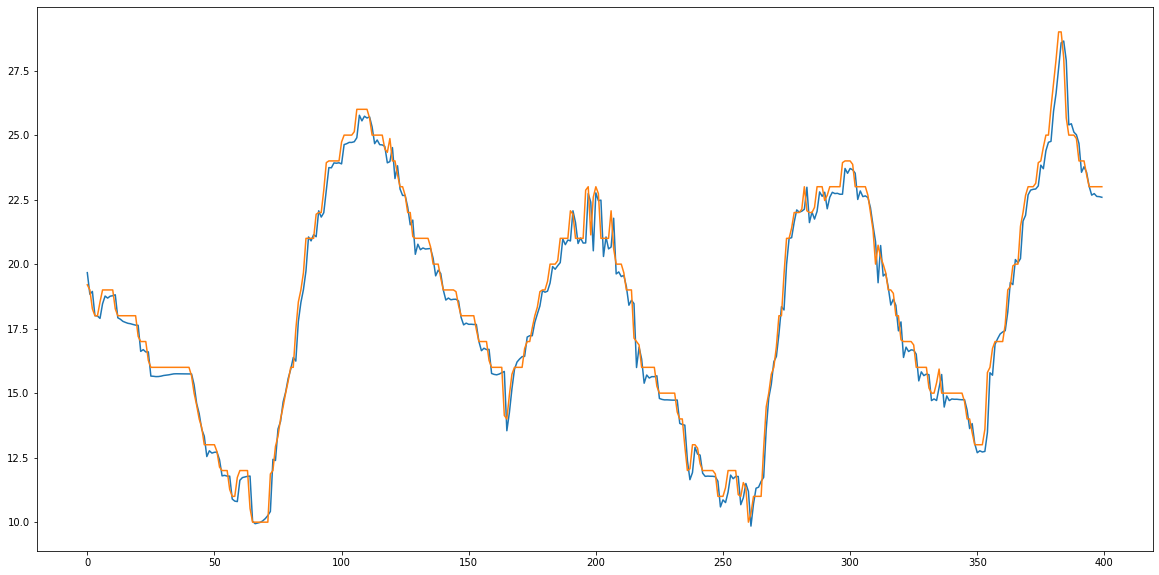

Iter:  51 train:  0.01795487376531312 val:  0.022804718217178884
Iter time:  0.7126259980723262
Iter:  52 train:  0.01788518171358635 val:  0.02309614810152023
Iter time:  0.7100753039121628
Saving...
Iter:  53 train:  0.017833110886035664 val:  0.02267869811473885
Iter time:  0.7545581869781017
Iter:  54 train:  0.017923953747473707 val:  0.023529151787654513
Iter time:  0.7233046749606729
Iter:  55 train:  0.0183382385556172 val:  0.022945194703222836
Iter time:  0.7363035436719656
Iter:  56 train:  0.01784419030600798 val:  0.02303916005947947
Iter time:  0.7413700046017766
Iter:  57 train:  0.018001920313965032 val:  0.023030672399001643
Iter time:  0.7343793110921979
Iter:  58 train:  0.017865036211260062 val:  0.022772208821896744
Iter time:  0.7342894030734897
Iter:  59 train:  0.018235938020667253 val:  0.022918658910476182
Iter time:  0.7105407500639558
Iter:  60 train:  0.01781830313264314 val:  0.023168945915455305
Iter time:  0.7361589092761278
mse:  0.25981116 mae:  0.3580

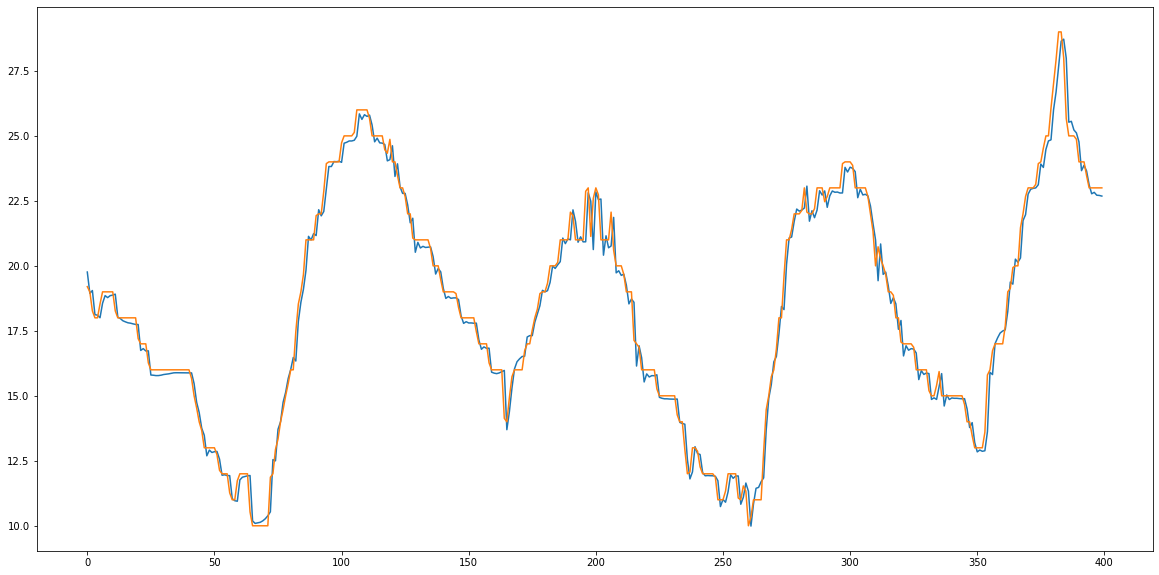

Iter:  61 train:  0.01801342308541173 val:  0.022778573499869052
Iter time:  0.7323517156764865
Iter:  62 train:  0.017886120216337262 val:  0.02306578454448407
Iter time:  0.7431243704631925
Iter:  63 train:  0.017954690625842016 val:  0.022796137343532693
Iter time:  0.6768874004483223
Iter:  64 train:  0.01804077578167482 val:  0.02378997514020178
Iter time:  0.620753793977201
Iter:  65 train:  0.018477899009530185 val:  0.02272362249122427
Iter time:  0.6298393364995718
Iter:  66 train:  0.01784348708030297 val:  0.02282760650256771
Iter time:  0.7289500860497355
Iter:  67 train:  0.018032030191728575 val:  0.023445020204309042
Iter time:  0.7392116971313953
Iter:  68 train:  0.017916091653054404 val:  0.022794307401388002
Iter time:  0.7129575796425343
Iter:  69 train:  0.01797232626280828 val:  0.022778695441752022
Iter time:  0.7314680330455303
Iter:  70 train:  0.017930365715130948 val:  0.022861084115878356
Iter time:  0.7426381753757596
mse:  0.25295246 mae:  0.33415455


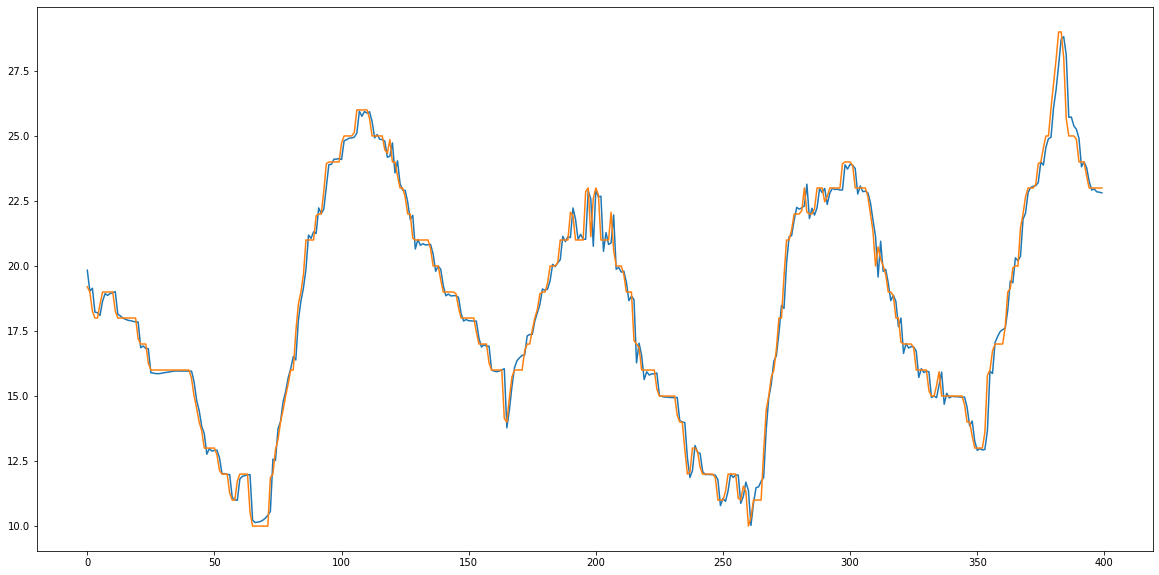

Iter:  71 train:  0.017877426993045738 val:  0.022692353774684728
Iter time:  0.7296138033270836
Iter:  72 train:  0.01795896266381302 val:  0.022812111333580028
Iter time:  0.7380294110625982
Iter:  73 train:  0.017934155297608084 val:  0.02279929813167534
Iter time:  0.7322871154174209
Iter:  74 train:  0.01788842651365054 val:  0.02296969342483784
Iter time:  0.7245455347001553
Iter:  75 train:  0.018167840031633808 val:  0.023543244867397162
Iter time:  0.7330153938382864
Iter:  76 train:  0.01821279979258835 val:  0.022822523005433512
Iter time:  0.7392615946009755
Iter:  77 train:  0.018099548204925563 val:  0.02319995575511527
Iter time:  0.7333843531087041
Iter:  78 train:  0.0178858997449248 val:  0.02292933871168042
Iter time:  0.7337533878162503
Iter:  79 train:  0.018039037025741306 val:  0.022741392894244143
Iter time:  0.7312907325103879
Iter:  80 train:  0.018053475219248313 val:  0.022711672696856214
Iter time:  0.7313287276774645
mse:  0.24965687 mae:  0.34590134


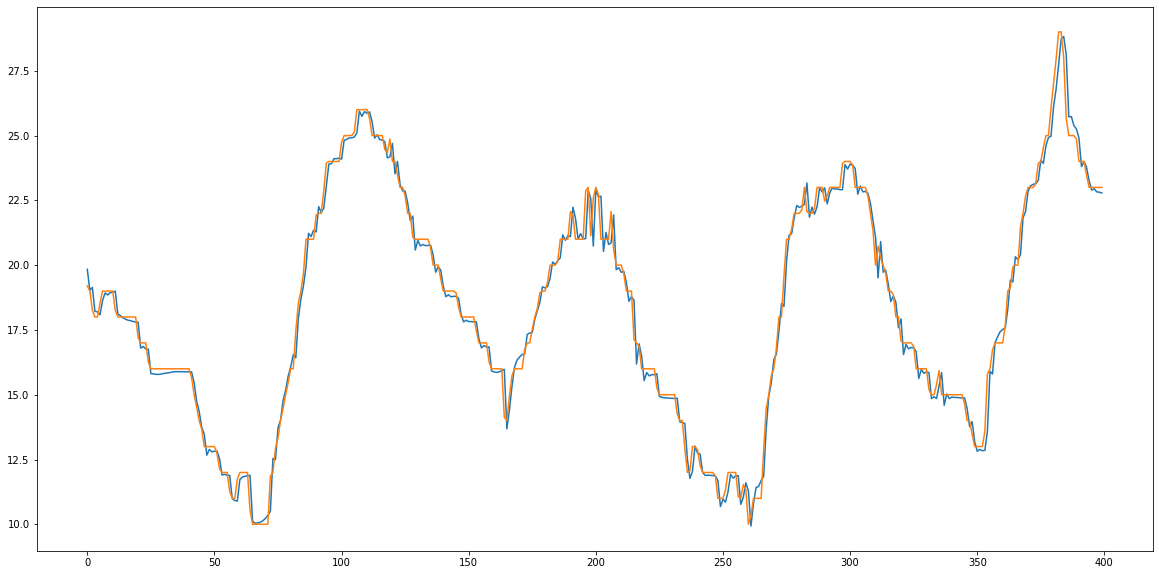

Iter:  81 train:  0.01799742273007777 val:  0.02284176170033278
Iter time:  0.7302626240998507
Iter:  82 train:  0.01784641156177652 val:  0.023376074506324413
Iter time:  0.7383539071306586
Iter:  83 train:  0.01794231575956423 val:  0.022824709960924255
Iter time:  0.733139798976481
Iter:  84 train:  0.018408522296647873 val:  0.023464388225668695
Iter time:  0.7386676706373692
Iter:  85 train:  0.01813473879667077 val:  0.022846034493969727
Iter time:  0.7324597835540771
Iter:  86 train:  0.01825868330510709 val:  0.02279901770335874
Iter time:  0.7389982752501965
Iter:  87 train:  0.017895145192599278 val:  0.022836198389773195
Iter time:  0.723408424295485


In [85]:
epochs = 1000
loss = nn.MSELoss()
patience = 35
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    iteration_start = time.monotonic()
    for batch_x, batch_y in train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output, alphas, betas = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "imv_lstm_sml2010.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    iteration_end = time.monotonic()
    print("Iter time: ", iteration_end - iteration_start)
    if(i % 10 == 0):
        preds = preds*(y_train_max - y_train_min) + y_train_min
        true = true*(y_train_max - y_train_min) + y_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [86]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    alphas_freeze_2 = []
    betas_freeze_2 = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output, a, b = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        alphas_freeze_2.append(a.detach().cpu().numpy())
        betas_freeze_2.append(b.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)
alphas_freeze_2 = np.concatenate(alphas_freeze_2)
betas_freeze_2 = np.concatenate(betas_freeze_2)

In [87]:
alphas_freeze_2 = alphas_freeze_2.mean(axis=0)
betas_freeze_2 = betas_freeze_2.mean(axis=0)

In [88]:
alphas_freeze_2 = alphas_freeze_2[..., 0]
betas_freeze_2 = betas_freeze_2[..., 0]

In [89]:
alphas_freeze_2 = alphas_freeze_2.transpose(1, 0)

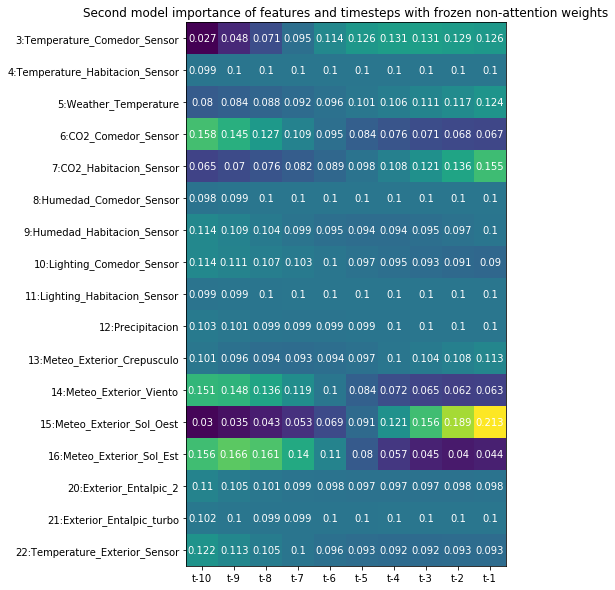

In [90]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(alphas_freeze_2)
ax.set_xticks(np.arange(X_train_t.shape[1]))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], -1, -1)])
ax.set_yticklabels(cols)
for i in range(len(cols)):
    for j in range(X_train_t.shape[1]):
        text = ax.text(j, i, round(alphas_freeze_2[i, j], 3),
                       ha="center", va="center", color="w")
ax.set_title("Second model importance of features and timesteps with frozen non-attention weights")
#fig.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x7f37ce0de198>,
 <a list of 17 Text xticklabel objects>)

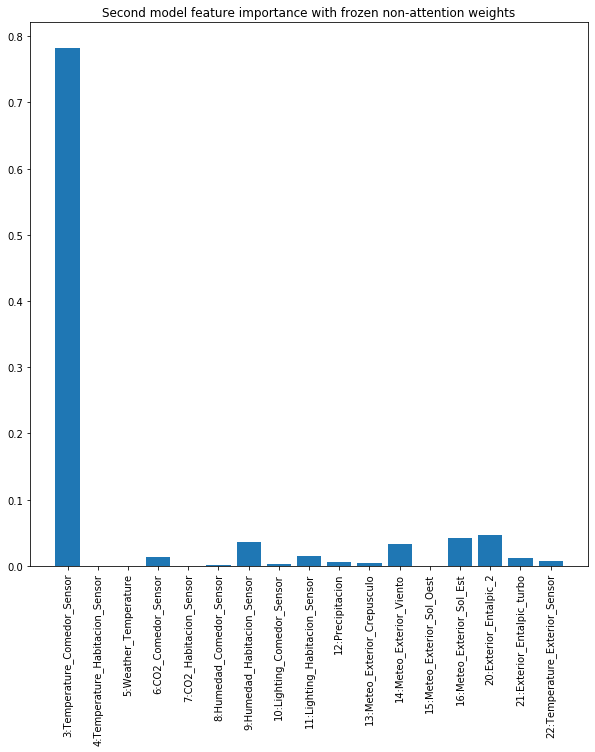

In [91]:
plt.figure(figsize=(10, 10))
plt.title("Second model feature importance with frozen non-attention weights")
plt.bar(range(len(cols)), betas_freeze_2)
plt.xticks(ticks=range(len(cols)), labels=cols, rotation=90)

In [92]:
# difference between two runs

In [93]:
alphas_diff = np.abs(alphas_freeze_2 - alphas_freeze_1)

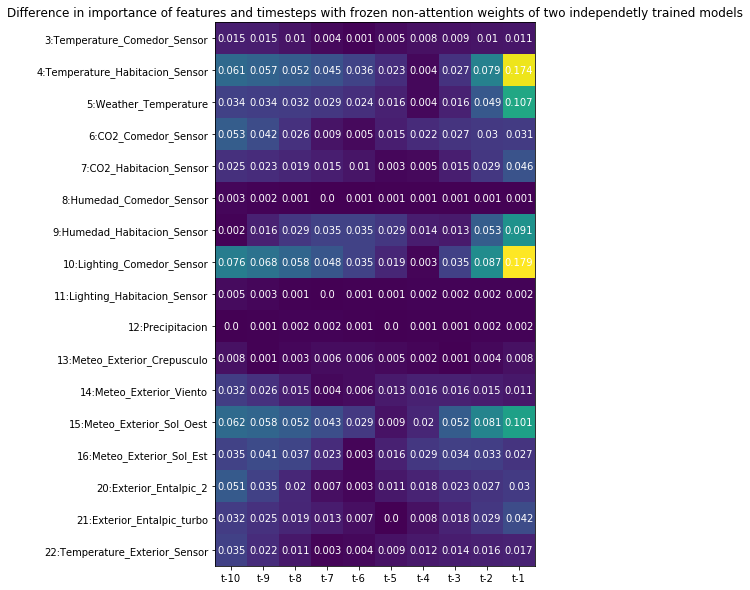

In [94]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(alphas_diff)
ax.set_xticks(np.arange(X_train_t.shape[1]))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], -1, -1)])
ax.set_yticklabels(cols)
for i in range(len(cols)):
    for j in range(X_train_t.shape[1]):
        text = ax.text(j, i, round(alphas_diff[i, j], 3),
                       ha="center", va="center", color="w")
ax.set_title("Difference in importance of features and timesteps with frozen non-attention weights of two independetly trained models")
#fig.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x7f3810191208>,
 <a list of 17 Text xticklabel objects>)

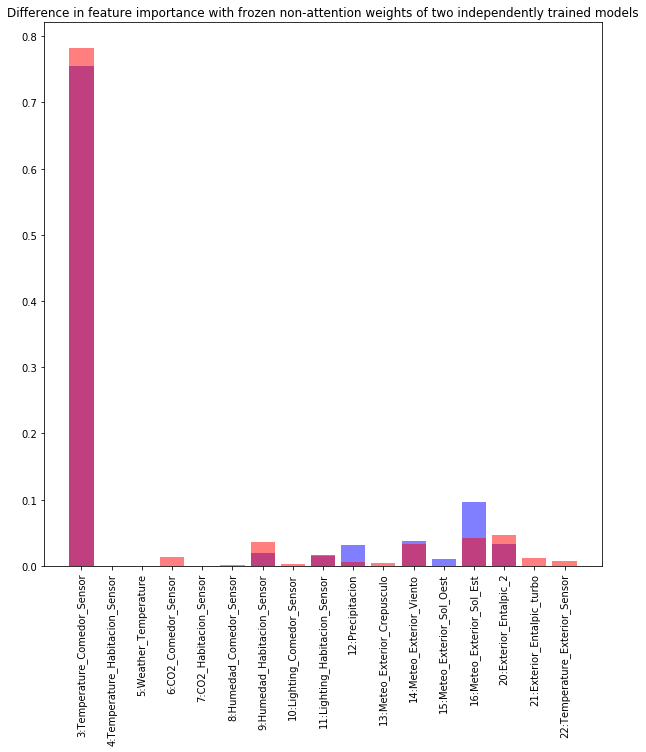

In [97]:
plt.figure(figsize=(10, 10))
plt.title("Difference in feature importance with frozen non-attention weights of two independently trained models")
plt.bar(range(len(cols)), betas_freeze_1, fc=(0, 0, 1, 0.5))
plt.bar(range(len(cols)), betas_freeze_2, fc=(1, 0, 0, 0.5))
plt.xticks(ticks=range(len(cols)), labels=cols, rotation=90)